<a href="https://colab.research.google.com/github/Raswanth-Prasath/NGSIM-Driving-Behavior-Analysis/blob/main/NGSIM_Driving_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats

In [5]:
# Define column names for the data files
column_names = ['Vehicle ID', 'Frame ID', 'Lane ID', 'LocalY', 'Mean Speed', 'Mean Acceleration', 'Vehicle length', 'Vehicle Class ID', 'Follower ID', 'Leader ID']  # replace with actual column names
moto_column_names = ['Vehicle ID', 'Frame ID', 'Lane ID', 'LocalY', 'Mean Speed', 'Mean Acceleration', 'Vehicle length', 'Vehicle Class ID']  # replace with actual column names

# Read DATA.txt (adjust delimiter if needed)
data = pd.read_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA (NO MOTORCYCLES).txt", delimiter=r"\s+", header=None, names=column_names)  # \s+ for multiple spaces
motorcycles = pd.read_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\MOTORCYCLES.txt", delimiter=r"\s+", header=None, names=moto_column_names)

In [6]:
data.to_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA.csv", index=False)
motorcycles.to_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\MOTORCYCLES.csv", index=False)

In [7]:
# Add missing columns to motorcycles (Leader ID, Follower ID)
motorcycles["Follower ID"] = -1
motorcycles["Leader ID"] = -1

# Combine datasets
combined = pd.concat([data, motorcycles], ignore_index=True)

In [16]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple

@dataclass
class CarFollowingPair:
    """
    Represents a validated car-following pair with all relevant information
    """
    leader_id: int
    follower_id: int
    
    start_frame: int
    end_frame: int
    lane_id: int
    
    metrics: Dict = None

    @property
    def duration(self) -> float:
        """Duration of car-following episode in seconds"""
        return (self.end_frame - self.start_frame + 1) * 0.1  # Convert frames to seconds

class CarFollowingIdentifier:
    """
    Identifies and validates car-following pairs in trajectory data
    """
    def __init__(self, min_duration: float = 20.0,
                 min_spacing: float = 2.0,
                 max_spacing: float = 100.0):
        """
        Initialize with validation criteria
        
        Parameters:
        min_duration: Minimum duration in seconds for valid car-following
        min_spacing: Minimum allowed spacing between vehicles (meters)
        max_spacing: Maximum allowed spacing between vehicles (meters)
        """
        self.min_duration = min_duration
        self.min_frames = int(min_duration * 10)  # Convert to frames (0.1s intervals)
        self.min_spacing = min_spacing
        self.max_spacing = max_spacing
        
    def identify_pairs(self, df: pd.DataFrame) -> List[CarFollowingPair]:
        """
        Main method to identify valid car-following pairs, with integrated leader-follower validation
        
        Parameters:
        df: DataFrame with columns for Vehicle_ID, Frame_ID, Lane_ID, LocalY, Leader_ID, Follower_ID
        
        Returns:
        List of validated CarFollowingPair objects
        """
        valid_pairs = []
        pairs_before_validation = 0
        pairs_after_validation = 0
        
        # Step 1: Group data by lane
        for lane_id, lane_data in df.groupby('Lane_ID'):
            # Skip special lanes (like merge lanes or shoulders)
            if lane_id > 6:  # Assuming regular lanes are 1-6
                continue
                
            # Step 2: Process each time window in the lane
            frames = sorted(lane_data['Frame_ID'].unique())
            
            # Step 3: Track ongoing pairs
            current_pairs = {}
            
            for frame in frames:
                frame_data = lane_data[lane_data['Frame_ID'] == frame]
                
                # Sort vehicles by position to identify leader-follower relationships
                frame_vehicles = frame_data.sort_values('LocalY', ascending=False)
                
                # Step 4: Check each consecutive pair of vehicles
                for i in range(len(frame_vehicles) - 1):
                    leader = frame_vehicles.iloc[i]
                    follower = frame_vehicles.iloc[i + 1]
                    
                    # Calculate spacing
                    spacing = leader['LocalY'] - follower['LocalY']
                    pairs_before_validation += 1
                    
                    # Get vehicle IDs for relationship validation
                    leader_id = leader['Vehicle_ID']
                    follower_id = follower['Vehicle_ID']
                    follower_leader_id = follower['Leader_ID']
                    leader_follower_id = leader['Follower_ID']
                    
                    # Validate the leader-follower relationship:
                    # 1. If explicit relationships exist (non -1), they must be correct
                    # 2. If no explicit relationships (-1), allow validation by spacing
                    valid_relationship = False
                    
                    if follower_leader_id != -1 or leader_follower_id != -1:
                        # At least one explicit relationship exists - it must be correct
                        leader_match = follower_leader_id == leader_id
                        follower_match = leader_follower_id == follower_id
                        valid_relationship = leader_match or follower_match
                    else:
                        # No explicit relationships - allow validation by spacing
                        valid_relationship = True
                    
                    # Both the relationship and spacing must be valid
                    if valid_relationship and self.min_spacing <= spacing <= self.max_spacing:
                        pairs_after_validation += 1
                        pair_id = (leader_id, follower_id)
                        
                        if pair_id not in current_pairs:
                            # Start new pair tracking
                            current_pairs[pair_id] = {
                                'start_frame': frame,
                                'current_frame': frame,
                                'lane_id': lane_id
                            }
                        else:
                            # Update existing pair
                            current_pairs[pair_id]['current_frame'] = frame
                    else:
                        # Invalid pair - end pair if exists
                        pair_id = (leader_id, follower_id)
                        self._check_and_add_pair(current_pairs, pair_id, valid_pairs)
                
            # Process any remaining pairs at the end of the lane
            for pair_id in list(current_pairs.keys()):
                self._check_and_add_pair(current_pairs, pair_id, valid_pairs)
        
        print(f"Pairs before validation: {pairs_before_validation}")
        print(f"Pairs after validation: {pairs_after_validation}")
        return valid_pairs
    
    def _check_and_add_pair(self, current_pairs: Dict, 
                           pair_id: Tuple[int, int],
                           valid_pairs: List[CarFollowingPair]) -> None:
        """
        Validates and adds a car-following pair if it meets duration criteria
        """
        if pair_id in current_pairs:
            pair_data = current_pairs[pair_id]
            duration_frames = pair_data['current_frame'] - pair_data['start_frame'] + 1
            
            if duration_frames >= self.min_frames:
                # Create validated pair
                valid_pairs.append(CarFollowingPair(
                    leader_id=pair_id[0],
                    follower_id=pair_id[1],
                    start_frame=pair_data['start_frame'],
                    end_frame=pair_data['current_frame'],
                    lane_id=pair_data['lane_id']
                ))
            
            # Remove pair from tracking
            del current_pairs[pair_id]
    
    def compute_pair_metrics(self, pair: CarFollowingPair, df: pd.DataFrame) -> Dict:
        """
        Computes detailed metrics for a validated car-following pair with proper handling of zero speeds
        
        Parameters:
        pair: CarFollowingPair object
        df: Original trajectory DataFrame
        
        Returns:
        Dictionary of computed metrics
        """
        # Get leader and follower trajectories
        leader_data = df[(df['Vehicle_ID'] == pair.leader_id) & 
                        (df['Frame_ID'] >= pair.start_frame) & 
                        (df['Frame_ID'] <= pair.end_frame)]
        
        follower_data = df[(df['Vehicle_ID'] == pair.follower_id) & 
                        (df['Frame_ID'] >= pair.start_frame) & 
                        (df['Frame_ID'] <= pair.end_frame)]
        
        # Compute spacing statistics
        spacing = leader_data['LocalY'].values - follower_data['LocalY'].values
        
        # Compute speed difference statistics
        speed_diff = leader_data['Speed'].values - follower_data['Speed'].values
        
        # Compute time headway with careful handling of zero speeds
        follower_speeds = follower_data['Speed'].values
        
        # Create a mask for non-zero speeds to avoid division by zero
        non_zero_speed_mask = follower_speeds > 0.01  # Small threshold to handle near-zero speeds
        
        # Only calculate time headway where speed is non-zero
        if np.any(non_zero_speed_mask):
            # Calculate time headway only for non-zero speeds
            valid_spacings = spacing[non_zero_speed_mask]
            valid_speeds = follower_speeds[non_zero_speed_mask]
            time_headway = valid_spacings / valid_speeds
            
            # Remove any extreme values that might still occur
            reasonable_headway_mask = (time_headway > 0) & (time_headway < 20)  # Filter unreasonable values
            valid_headway = time_headway[reasonable_headway_mask] if np.any(reasonable_headway_mask) else np.array([])
        else:
            # No valid speeds for calculation
            valid_headway = np.array([])
        
        # Handle empty arrays for edge cases
        if len(valid_headway) == 0:
            headway_stats = {
                'mean': np.nan,
                'std': np.nan,
                'min': np.nan,
                'max': np.nan
            }
        else:
            headway_stats = {
                'mean': np.mean(valid_headway),
                'std': np.std(valid_headway),
                'min': np.min(valid_headway),
                'max': np.max(valid_headway)
            }
        
        return {
            'spacing': {
                'mean': np.mean(spacing),
                'std': np.std(spacing),
                'min': np.min(spacing),
                'max': np.max(spacing)
            },
            'speed_difference': {
                'mean': np.mean(speed_diff),
                'std': np.std(speed_diff),
                'min': np.min(speed_diff),
                'max': np.max(speed_diff)
            },
            'time_headway': headway_stats
        }

def main():
    # Example usage
    # Read the data file
    df = pd.read_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA (NO MOTORCYCLES).txt", delimiter='\s+', header=None,
                     names=['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                           'Speed', 'Acceleration', 'Vehicle_Length',
                           'Vehicle_Class', 'Follower_ID', 'Leader_ID'])
    
    # Initialize identifier
    identifier = CarFollowingIdentifier(
        min_duration=20.0,  # 20 seconds minimum
        min_spacing=2.0,    # 2 meters minimum spacing
        max_spacing=100.0   # 100 meters maximum spacing
    )
    
    # Find car-following pairs
    pairs = identifier.identify_pairs(df)
    
    # Print summary
    print(f"Found {len(pairs)} valid car-following pairs")
    
    # Export all pairs to CSV
    export_pairs_to_csv(pairs, df, identifier, "car_following_pairs.csv")
    
    # Analyze first few pairs
    for i, pair in enumerate(pairs[:5]):
        print(f"\nPair {i+1}:")
        print(f"Leader ID: {pair.leader_id}")
        print(f"Follower ID: {pair.follower_id}")
        print(f"Duration: {pair.duration:.1f} seconds")
        print(f"Lane: {pair.lane_id}")
        
        # Compute and print metrics
        metrics = identifier.compute_pair_metrics(pair, df)
        print("\nMetrics:")
        for metric, values in metrics.items():
            print(f"\n{metric}:")
            for stat, value in values.items():
                print(f"  {stat}: {value:.2f}")

def export_pairs_to_csv(pairs, df, identifier, filename):
    """
    Export all car-following pairs with their metrics to a CSV file
    
    Parameters:
    pairs: List of CarFollowingPair objects
    df: Original trajectory DataFrame
    identifier: CarFollowingIdentifier instance for computing metrics
    filename: Name of the output CSV file
    """
    # Prepare a list to hold all pair data
    all_pairs_data = []
    
    # Process each pair
    for i, pair in enumerate(pairs):
        # Compute metrics for this pair
        metrics = identifier.compute_pair_metrics(pair, df)
        
        # Create a dictionary with all relevant data
        pair_data = {
            'pair_id': i + 1,
            'leader_id': pair.leader_id,
            'follower_id': pair.follower_id,
            'start_frame': pair.start_frame,
            'end_frame': pair.end_frame,
            'lane_id': pair.lane_id,
            'duration_seconds': pair.duration,
            'mean_spacing': metrics['spacing']['mean'],
            'std_spacing': metrics['spacing']['std'],
            'min_spacing': metrics['spacing']['min'],
            'max_spacing': metrics['spacing']['max'],
            'mean_speed_diff': metrics['speed_difference']['mean'],
            'std_speed_diff': metrics['speed_difference']['std'],
            'min_speed_diff': metrics['speed_difference']['min'],
            'max_speed_diff': metrics['speed_difference']['max'],
            'mean_time_headway': metrics['time_headway']['mean'],
            'std_time_headway': metrics['time_headway']['std'],
            'min_time_headway': metrics['time_headway']['min'],
            'max_time_headway': metrics['time_headway']['max']
        }
        
        all_pairs_data.append(pair_data)
    
    # Convert to DataFrame
    pairs_df = pd.DataFrame(all_pairs_data)
    
    # Save to CSV
    pairs_df.to_csv(filename, index=False)
    print(f"Exported {len(pairs)} car-following pairs to {filename}")
        
if __name__ == "__main__":
    main()

Pairs before validation: 966462
Pairs after validation: 963929
Found 2029 valid car-following pairs
Exported 2029 car-following pairs to car_following_pairs.csv

Pair 1:
Leader ID: 47.0
Follower ID: 64.0
Duration: 21.8 seconds
Lane: 1

Metrics:

spacing:
  mean: 52.44
  std: 18.54
  min: 35.11
  max: 99.71

speed_difference:
  mean: 2.83
  std: 2.71
  min: -1.43
  max: 8.23

time_headway:
  mean: 4.71
  std: 1.17
  min: 3.39
  max: 8.14

Pair 2:
Leader ID: 2142.0
Follower ID: 2153.0
Duration: 20.5 seconds
Lane: 1

Metrics:

spacing:
  mean: 66.29
  std: 15.14
  min: 45.03
  max: 99.59

speed_difference:
  mean: 2.67
  std: 1.95
  min: -0.61
  max: 6.10

time_headway:
  mean: 4.73
  std: 1.42
  min: 2.75
  max: 8.12

Pair 3:
Leader ID: 2.0
Follower ID: 17.0
Duration: 26.0 seconds
Lane: 1

Metrics:

spacing:
  mean: 36.46
  std: 10.12
  min: 19.77
  max: 57.29

speed_difference:
  mean: 1.36
  std: 1.29
  min: -1.81
  max: 4.81

time_headway:
  mean: 2.82
  std: 0.35
  min: 2.17
  max: 4

In [12]:
import pandas as pd
import numpy as np

def analyze_lane7_travel_times(file_path):
    """
    Analyze the travel times of vehicles in lane 7 (on-ramp) of the NGSIM dataset.
    
    Parameters:
    file_path (str): Path to the NGSIM data file
    
    Returns:
    dict: Dictionary containing min, max, mean travel times and vehicle counts
    """
    # Read the NGSIM data
    print("Reading NGSIM data file...")
    
    # Use the correct column names based on the dataset documentation
    column_names = [
        'Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
        'Speed', 'Acceleration', 'Vehicle_Length',
        'Vehicle_Class', 'Follower_ID', 'Leader_ID'
    ]
    
    # Read the data with proper delimiter (spaces)
    df = pd.read_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA (NO MOTORCYCLES).txt", delimiter=r'\s+', header=None, names=column_names)
    
    # Filter to only include lane 7 (on-ramp)
    lane7_data = df[df['Lane_ID'] == 7].copy()
    print(f"Found {lane7_data['Vehicle_ID'].nunique()} vehicles in lane 7")
    
    if len(lane7_data) == 0:
        return {"error": "No data found for lane 7"}
    
    # Calculate travel times per vehicle
    # First, get the entry and exit frames for each vehicle
    vehicle_travel_data = []
    
    for vehicle_id in lane7_data['Vehicle_ID'].unique():
        vehicle_frames = lane7_data[lane7_data['Vehicle_ID'] == vehicle_id]['Frame_ID']
        
        if len(vehicle_frames) < 2:
            continue  # Skip vehicles with insufficient data
        
        entry_frame = vehicle_frames.min()
        exit_frame = vehicle_frames.max()
        
        # Get positions at entry and exit
        entry_position = lane7_data[(lane7_data['Vehicle_ID'] == vehicle_id) & 
                                    (lane7_data['Frame_ID'] == entry_frame)]['LocalY'].values[0]
        exit_position = lane7_data[(lane7_data['Vehicle_ID'] == vehicle_id) & 
                                   (lane7_data['Frame_ID'] == exit_frame)]['LocalY'].values[0]
        
        # Calculate travel distance
        travel_distance = exit_position - entry_position
        
        # Calculate travel time in seconds (frames are 0.1 seconds apart)
        travel_time = (exit_frame - entry_frame) * 0.1
        
        # Calculate average speed
        avg_speed = travel_distance / travel_time if travel_time > 0 else 0
        
        # Only include vehicles that traveled at least 10 meters to filter out noise
        # and vehicles that were genuinely using the on-ramp (not just passing through)
        if travel_distance >= 10:
            vehicle_travel_data.append({
                'vehicle_id': vehicle_id,
                'entry_frame': entry_frame,
                'exit_frame': exit_frame,
                'entry_position': entry_position,
                'exit_position': exit_position,
                'travel_distance': travel_distance,
                'travel_time': travel_time,
                'avg_speed': avg_speed
            })
    
    # Convert to DataFrame
    travel_df = pd.DataFrame(vehicle_travel_data)
    
    if len(travel_df) == 0:
        return {"error": "No valid travel data found for lane 7"}
    
    # Get statistics
    min_travel_time = travel_df['travel_time'].min()
    max_travel_time = travel_df['travel_time'].max()
    mean_travel_time = travel_df['travel_time'].mean()
    median_travel_time = travel_df['travel_time'].median()
    
    # Get details about vehicles with min and max travel times
    min_vehicle = travel_df.loc[travel_df['travel_time'].idxmin()]
    max_vehicle = travel_df.loc[travel_df['travel_time'].idxmax()]
    
    # Print results
    print("\nLane 7 (On-ramp) Travel Time Analysis:")
    print(f"Number of vehicles analyzed: {len(travel_df)}")
    print(f"Minimum travel time: {min_travel_time:.2f} seconds (Vehicle {min_vehicle['vehicle_id']})")
    print(f"Maximum travel time: {max_travel_time:.2f} seconds (Vehicle {max_vehicle['vehicle_id']})")
    print(f"Mean travel time: {mean_travel_time:.2f} seconds")
    print(f"Median travel time: {median_travel_time:.2f} seconds")
    
    # Additional stats about the min and max cases
    print("\nDetails for vehicle with minimum travel time:")
    print(f"  Vehicle ID: {min_vehicle['vehicle_id']}")
    print(f"  Travel distance: {min_vehicle['travel_distance']:.2f} meters")
    print(f"  Average speed: {min_vehicle['avg_speed']:.2f} m/s")
    
    print("\nDetails for vehicle with maximum travel time:")
    print(f"  Vehicle ID: {max_vehicle['vehicle_id']}")
    print(f"  Travel distance: {max_vehicle['travel_distance']:.2f} meters")
    print(f"  Average speed: {max_vehicle['avg_speed']:.2f} m/s")
    
    # Create histogram of travel times
    travel_time_distribution = np.histogram(travel_df['travel_time'], bins=10)
    print("\nTravel Time Distribution (seconds):")
    for i, count in enumerate(travel_time_distribution[0]):
        bin_start = travel_time_distribution[1][i]
        bin_end = travel_time_distribution[1][i+1]
        print(f"  {bin_start:.1f} - {bin_end:.1f}: {count} vehicles")
    
    return {
        "min_travel_time": min_travel_time,
        "max_travel_time": max_travel_time,
        "mean_travel_time": mean_travel_time,
        "median_travel_time": median_travel_time,
        "vehicles_analyzed": len(travel_df),
        "min_vehicle": min_vehicle.to_dict(),
        "max_vehicle": max_vehicle.to_dict()
    }

# Example usage
if __name__ == "__main__":
    # Update this path to match your data location
    file_path = "D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA (NO MOTORCYCLES).txt"
    results = analyze_lane7_travel_times(file_path)
    
    # Results are also returned as a dictionary for further analysis
    print("\nAnalysis complete!")

Reading NGSIM data file...
Found 197 vehicles in lane 7

Lane 7 (On-ramp) Travel Time Analysis:
Number of vehicles analyzed: 197
Minimum travel time: 2.00 seconds (Vehicle 989.0)
Maximum travel time: 39.10 seconds (Vehicle 3013.0)
Mean travel time: 15.48 seconds
Median travel time: 12.60 seconds

Details for vehicle with minimum travel time:
  Vehicle ID: 989.0
  Travel distance: 26.26 meters
  Average speed: 13.13 m/s

Details for vehicle with maximum travel time:
  Vehicle ID: 3013.0
  Travel distance: 102.08 meters
  Average speed: 2.61 m/s

Travel Time Distribution (seconds):
  2.0 - 5.7: 9 vehicles
  5.7 - 9.4: 49 vehicles
  9.4 - 13.1: 45 vehicles
  13.1 - 16.8: 18 vehicles
  16.8 - 20.6: 25 vehicles
  20.6 - 24.3: 17 vehicles
  24.3 - 28.0: 15 vehicles
  28.0 - 31.7: 9 vehicles
  31.7 - 35.4: 5 vehicles
  35.4 - 39.1: 5 vehicles

Analysis complete!


Analyzes statistical properties of car-following pairs and generates comprehensive visualizations and analyses.

**Car-Following Visualization**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

def load_data(file_path):
    """Load and process the trajectory data"""
    try:
        # Read data with numbered columns first
        data = pd.read_csv(file_path, delimiter='\s+', header=None)
        
        # Rename columns to match expected format
        data.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'Local_Y', 
                       'Speed', 'Acceleration', 'Vehicle_Length',
                       'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        logger.info(f"Successfully loaded data with {len(data)} rows")
        return data
        
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def find_car_following_pairs(data):
    """Identify car-following pairs that persist for at least 20 seconds"""
    pairs = []
    min_duration = 200  # 20 seconds (at 0.1s intervals)
    
    # Process each vehicle
    for vehicle_id in data['Vehicle_ID'].unique():
        vehicle_data = data[data['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
        
        # Find unique leaders (excluding -1 which indicates no leader)
        leaders = vehicle_data['Leader_ID'].unique()
        leaders = leaders[leaders != -1]
        
        for leader_id in leaders:
            # Get frames where this vehicle follows the current leader
            following_frames = vehicle_data[vehicle_data['Leader_ID'] == leader_id]['Frame_ID']
            
            if len(following_frames) >= min_duration:
                pairs.append({
                    'leader_id': leader_id,
                    'follower_id': vehicle_id,
                    'start_frame': following_frames.iloc[0],
                    'end_frame': following_frames.iloc[-1],
                    'lane': vehicle_data['Lane_ID'].iloc[0],
                    'duration': len(following_frames) * 0.1  # Convert to seconds
                })
    
    logger.info(f"Found {len(pairs)} car-following pairs")
    return pairs

def process_pair_data(data, selected_pairs):
    """Process data for selected car-following pairs"""
    pair_data = []
    
    for pair in selected_pairs:
        # Get trajectory data for leader and follower
        frames = range(int(pair['start_frame']), int(pair['end_frame']) + 1)
        
        leader_data = data[
            (data['Vehicle_ID'] == pair['leader_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        follower_data = data[
            (data['Vehicle_ID'] == pair['follower_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        # Combine data
        merged_data = pd.merge(
            leader_data, 
            follower_data,
            on='Frame_ID',
            suffixes=('_leader', '_follower')
        )
        
        time_data = []
        for _, row in merged_data.iterrows():
            time_data.append({
                'time': (row['Frame_ID'] - pair['start_frame']) * 0.1,
                'leader_speed': row['Speed_leader'],
                'follower_speed': row['Speed_follower'],
                'spacing': row['Local_Y_leader'] - row['Local_Y_follower'],
                'relative_speed': row['Speed_leader'] - row['Speed_follower']
            })
        
        pair_data.append({
            'pair_id': f"{pair['leader_id']}-{pair['follower_id']}",
            'time_data': pd.DataFrame(time_data)
        })
    
    return pair_data

def plot_pair_visualizations(pair_data):
    """Create visualizations for car-following pairs"""
    for pair in pair_data:
        time_data = pair['time_data']
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 15))
        fig.suptitle(f"Car-Following Pair Analysis: Pair {pair['pair_id']}", fontsize=16 )
        
        # Speed profiles
        axes[0].plot(time_data['time'], time_data['leader_speed'], 
                    label='Leader', color='#3B39FF', linewidth=2)
        axes[0].plot(time_data['time'], time_data['follower_speed'], 
                    label='Follower', color='#FF4040', linestyle='--', linewidth=2)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Speed (m/s)')
        axes[0].set_title('Speed Profiles')
        axes[0].grid(True)
        axes[0].legend()
        
        # Space gap
        axes[1].plot(time_data['time'], time_data['spacing'], 
                    color='green', linewidth=2)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Space Gap (m)')
        axes[1].set_title('Following Distance')
        axes[1].grid(True)
        
        # Relative speed
        axes[2].plot(time_data['time'], time_data['relative_speed'], 
                    color='purple', linewidth=2)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Relative Speed (m/s)')
        axes[2].set_title('Relative Speed (Leader - Follower)')
        axes[2].grid(True)
        
        # Add summary statistics
        stats_text = (
            f"Mean Space Gap: {time_data['spacing'].mean():.1f}m\n"
            f"Mean Relative Speed: {time_data['relative_speed'].mean():.2f}m/s\n"
            f"Duration: {len(time_data)*0.1:.1f}s"
        )
        plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f'pair_{pair["pair_id"]}_analysis_.png', dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Load data
    logger.info("Loading data...")
    data = load_data("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt")
    
    if len(data) == 0:
        logger.error("Failed to load data")
        return
        
    # Find car-following pairs
    logger.info("Finding car-following pairs...")
    pairs = find_car_following_pairs(data)
    
    if len(pairs) == 0:
        logger.error("No car-following pairs found")
        return
        
    # Select first 5 pairs
    selected_pairs = pairs[:5]
    
    # Process and visualize pairs
    logger.info("Processing and visualizing selected pairs...")
    pair_data = process_pair_data(data, selected_pairs)
    plot_pair_visualizations(pair_data)
    
    logger.info("Analysis complete!")

if __name__ == "__main__":
    main()

2025-02-21 08:47:32,368 - __main__ - INFO - Loading data...
2025-02-21 08:47:32,368 - __main__ - INFO - Loading data...
2025-02-21 08:47:32,368 - __main__ - INFO - Loading data...
2025-02-21 08:47:32,368 - __main__ - INFO - Loading data...
2025-02-21 08:47:32,368 - __main__ - INFO - Loading data...
2025-02-21 08:47:32,368 - __main__ - INFO - Loading data...
2025-02-21 08:47:35,205 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:47:35,205 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:47:35,205 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:47:35,205 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:47:35,205 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:47:35,205 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:47:35,211 - __main__ - INFO - Finding car-following pairs...
2025-02-21 08:47:35,211 - __main__ - INFO -

The following code uses the car_following_pairs.csv file generated from the previous code to analyze the car-following pairs and plot the results.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

def load_data(file_path):
    """Load and process the trajectory data"""
    try:
        # Read data with numbered columns first
        data = pd.read_csv(file_path, delimiter='\s+', header=None)
        
        # Rename columns to match expected format
        data.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'Local_Y', 
                       'Speed', 'Acceleration', 'Vehicle_Length',
                       'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        logger.info(f"Successfully loaded data with {len(data)} rows")
        return data
        
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def load_car_following_pairs(csv_file):
    """
    Load previously identified car-following pairs from a CSV file
    
    Parameters:
    csv_file: Path to the CSV file containing car-following pairs
    
    Returns:
    List of dictionaries with car-following pair information
    """
    try:
        # Load the CSV file
        pairs_df = pd.read_csv(csv_file)
        logger.info(f"Loaded {len(pairs_df)} car-following pairs from {csv_file}")
        
        # Convert dataframe rows to dictionaries for compatibility with existing code
        pairs = []
        for _, row in pairs_df.iterrows():
            pairs.append({
                'leader_id': row['leader_id'],
                'follower_id': row['follower_id'],
                'start_frame': row['start_frame'],
                'end_frame': row['end_frame'],
                'lane': row['lane_id'] if 'lane_id' in row else row.get('lane', 1),  # Handle both column naming conventions
                'duration': row['duration_seconds'] if 'duration_seconds' in row else 
                           (row['end_frame'] - row['start_frame'] + 1) * 0.1
            })
        
        return pairs
        
    except Exception as e:
        logger.error(f"Error loading car-following pairs: {e}")
        return []

def process_pair_data(data, selected_pairs):
    """Process data for selected car-following pairs"""
    pair_data = []
    
    for i, pair in enumerate(selected_pairs):
        # Get trajectory data for leader and follower
        frames = range(int(pair['start_frame']), int(pair['end_frame']) + 1)
        
        leader_data = data[
            (data['Vehicle_ID'] == pair['leader_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        follower_data = data[
            (data['Vehicle_ID'] == pair['follower_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        # Combine data
        merged_data = pd.merge(
            leader_data, 
            follower_data,
            on='Frame_ID',
            suffixes=('_leader', '_follower')
        )
        
        time_data = []
        for _, row in merged_data.iterrows():
            time_data.append({
                'time': (row['Frame_ID'] - pair['start_frame']) * 0.1,
                'leader_speed': row['Speed_leader'],
                'follower_speed': row['Speed_follower'],
                'spacing': row['Local_Y_leader'] - row['Local_Y_follower'],
                'relative_speed': row['Speed_leader'] - row['Speed_follower']
            })
        
        # Skip pairs with empty merged data
        if not time_data:
            logger.warning(f"Skipping pair {i+1} ({pair['leader_id']}-{pair['follower_id']}) due to empty merged data")
            continue
        
        pair_data.append({
            'pair_id': f"{pair['leader_id']}-{pair['follower_id']}",
            'time_data': pd.DataFrame(time_data)
        })
    
    return pair_data

def plot_pair_visualizations(pair_data, output_dir="."):
    """Create visualizations for car-following pairs"""
    for pair in pair_data:
        time_data = pair['time_data']
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 15))
        fig.suptitle(f"Car-Following Pair Analysis: Pair {pair['pair_id']}", fontsize=16 )
        
        # Speed profiles
        axes[0].plot(time_data['time'], time_data['leader_speed'], 
                    label='Leader', color='#3B39FF', linewidth=2)
        axes[0].plot(time_data['time'], time_data['follower_speed'], 
                    label='Follower', color='#FF4040', linestyle='--', linewidth=2)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Speed (m/s)')
        axes[0].set_title('Speed Profiles')
        axes[0].grid(True)
        axes[0].legend()
        
        # Space gap
        axes[1].plot(time_data['time'], time_data['spacing'], 
                    color='green', linewidth=2)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Space Gap (m)')
        axes[1].set_title('Following Distance')
        axes[1].grid(True)
        
        # Relative speed
        axes[2].plot(time_data['time'], time_data['relative_speed'], 
                    color='purple', linewidth=2)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Relative Speed (m/s)')
        axes[2].set_title('Relative Speed (Leader - Follower)')
        axes[2].grid(True)
        
        # Add summary statistics
        stats_text = (
            f"Mean Space Gap: {time_data['spacing'].mean():.1f}m\n"
            f"Mean Relative Speed: {time_data['relative_speed'].mean():.2f}m/s\n"
            f"Duration: {len(time_data)*0.1:.1f}s"
        )
        plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        output_path = f"{output_dir}/pair_{pair['pair_id']}_analysis.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        logger.info(f"Saved visualization to {output_path}")
        plt.close()

def main():
    # Define file paths
    data_file = "D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt"
    pairs_csv = "car_following_pairs.csv"
    output_dir = "visualizations"
    
    # Create output directory if it doesn't exist
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Load trajectory data
    logger.info("Loading trajectory data...")
    data = load_data(data_file)
    
    if len(data) == 0:
        logger.error("Failed to load trajectory data")
        return
    
    # Load car-following pairs from CSV
    logger.info(f"Loading car-following pairs from {pairs_csv}...")
    pairs = load_car_following_pairs(pairs_csv)
    
    if len(pairs) == 0:
        logger.error(f"No car-following pairs found in {pairs_csv}")
        return
    
    # Select pairs to visualize (first 5 by default)
    num_pairs = 5
    selected_pairs = pairs[:num_pairs]
    logger.info(f"Selected {len(selected_pairs)} pairs for visualization")
    
    # Process and visualize pairs
    logger.info("Processing and visualizing selected pairs...")
    pair_data = process_pair_data(data, selected_pairs)
    
    if len(pair_data) == 0:
        logger.error("No valid pair data generated for visualization")
        return
    
    plot_pair_visualizations(pair_data, output_dir)
    
    logger.info(f"Analysis complete! Visualizations saved to {output_dir}/")

if __name__ == "__main__":
    main()

2025-02-21 08:44:47,837 - __main__ - INFO - Loading trajectory data...
2025-02-21 08:44:47,837 - __main__ - INFO - Loading trajectory data...
2025-02-21 08:44:47,837 - __main__ - INFO - Loading trajectory data...
2025-02-21 08:44:47,837 - __main__ - INFO - Loading trajectory data...
2025-02-21 08:44:47,837 - __main__ - INFO - Loading trajectory data...
2025-02-21 08:44:50,809 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:44:50,809 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:44:50,809 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:44:50,809 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:44:50,809 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 08:44:50,812 - __main__ - INFO - Loading car-following pairs from car_following_pairs.csv...
2025-02-21 08:44:50,812 - __main__ - INFO - Loading car-following pairs from car_following_pairs.csv...
20

Following code is just to enhance  the visualization

2025-02-21 02:05:08,263 - __main__ - INFO - Loading data...
2025-02-21 02:05:08,263 - __main__ - INFO - Loading data...
2025-02-21 02:05:08,263 - __main__ - INFO - Loading data...
2025-02-21 02:05:11,152 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 02:05:11,152 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 02:05:11,152 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-21 02:05:11,154 - __main__ - INFO - Finding car-following pairs...
2025-02-21 02:05:11,154 - __main__ - INFO - Finding car-following pairs...
2025-02-21 02:05:11,154 - __main__ - INFO - Finding car-following pairs...
2025-02-21 02:05:15,942 - __main__ - INFO - Found 2056 car-following pairs
2025-02-21 02:05:15,942 - __main__ - INFO - Found 2056 car-following pairs
2025-02-21 02:05:15,942 - __main__ - INFO - Found 2056 car-following pairs
2025-02-21 02:05:15,948 - __main__ - INFO - Analyzing 5 selected car-following pairs...
2025-02-21 02:05:15,9

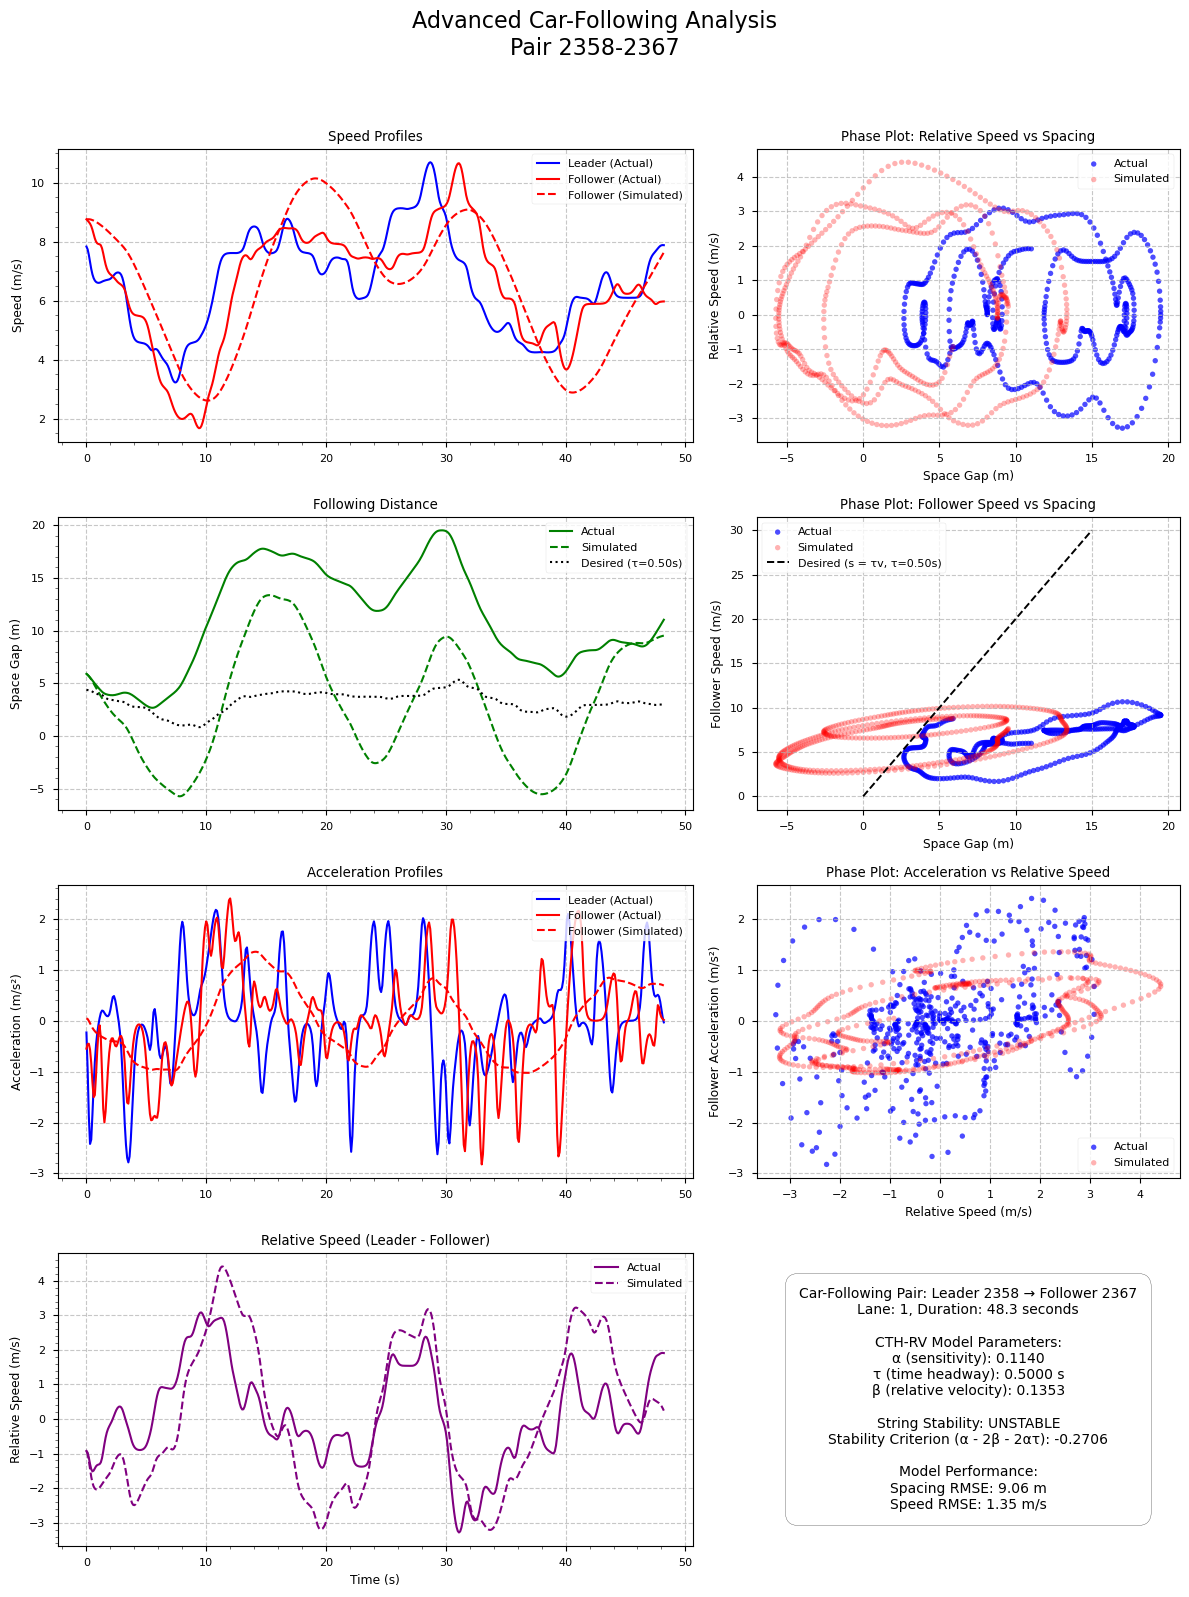

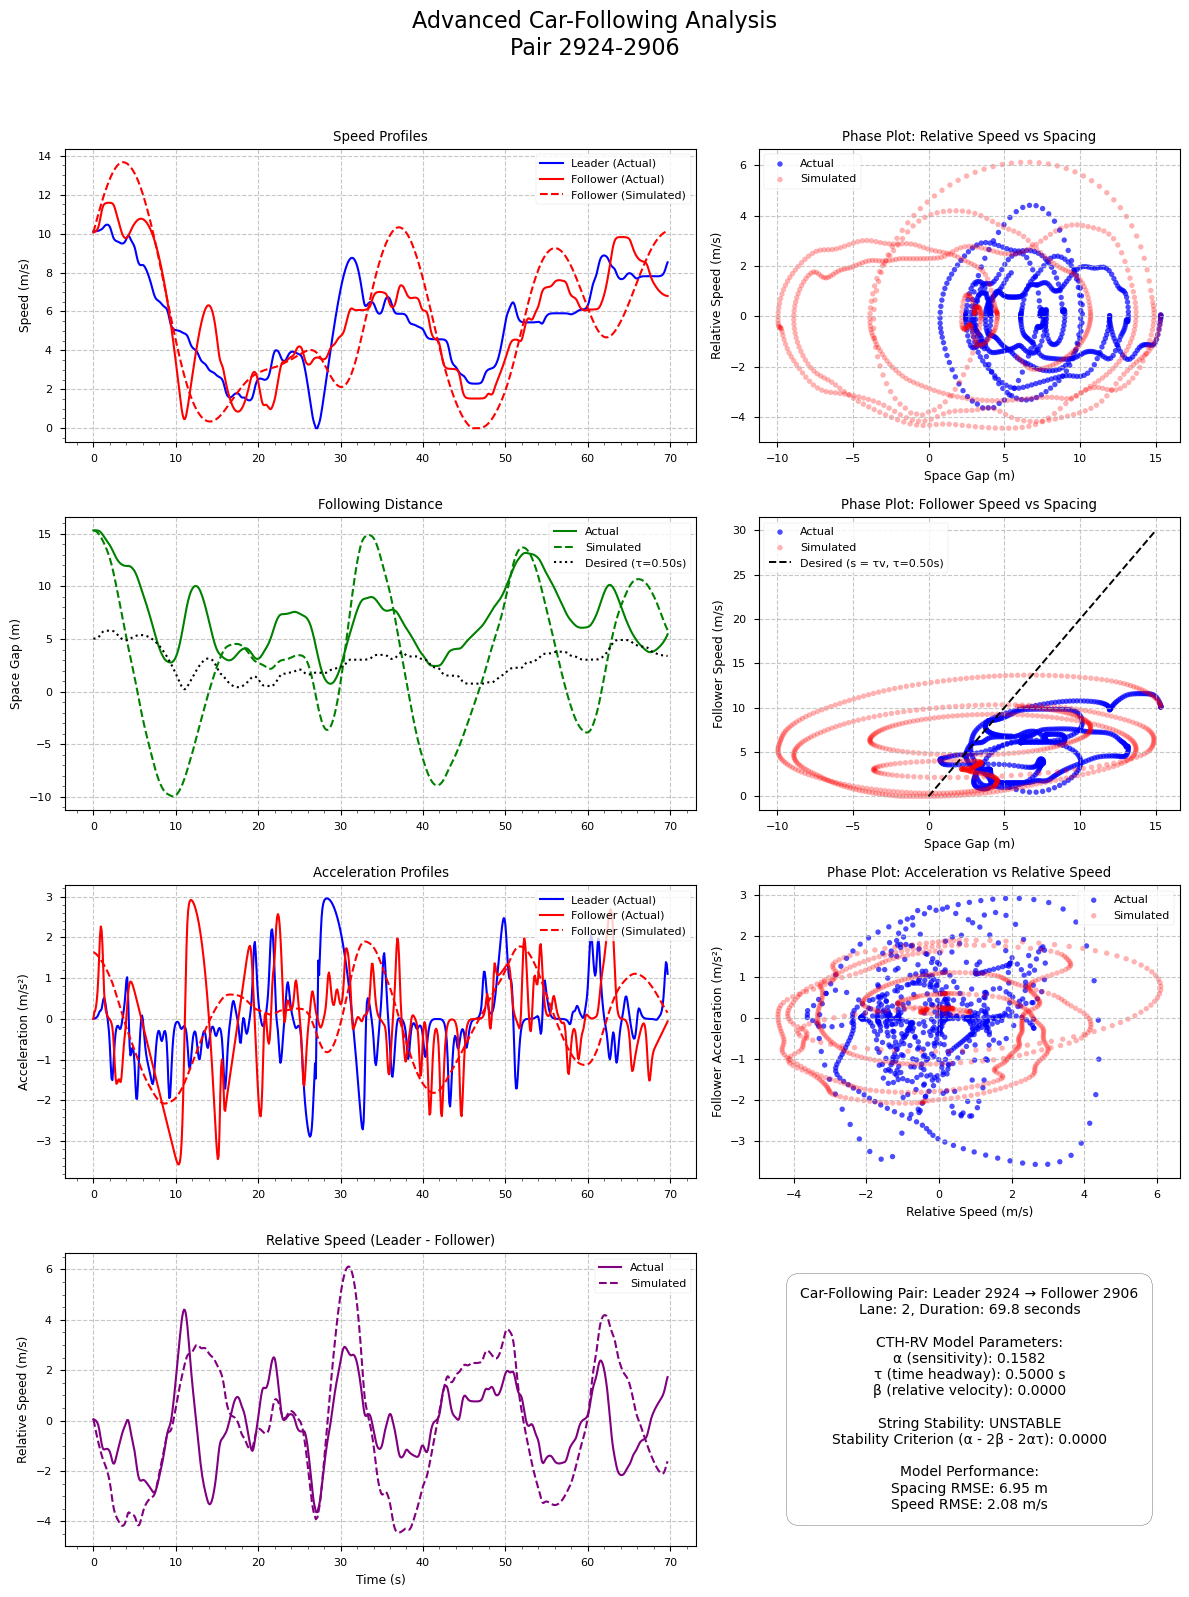

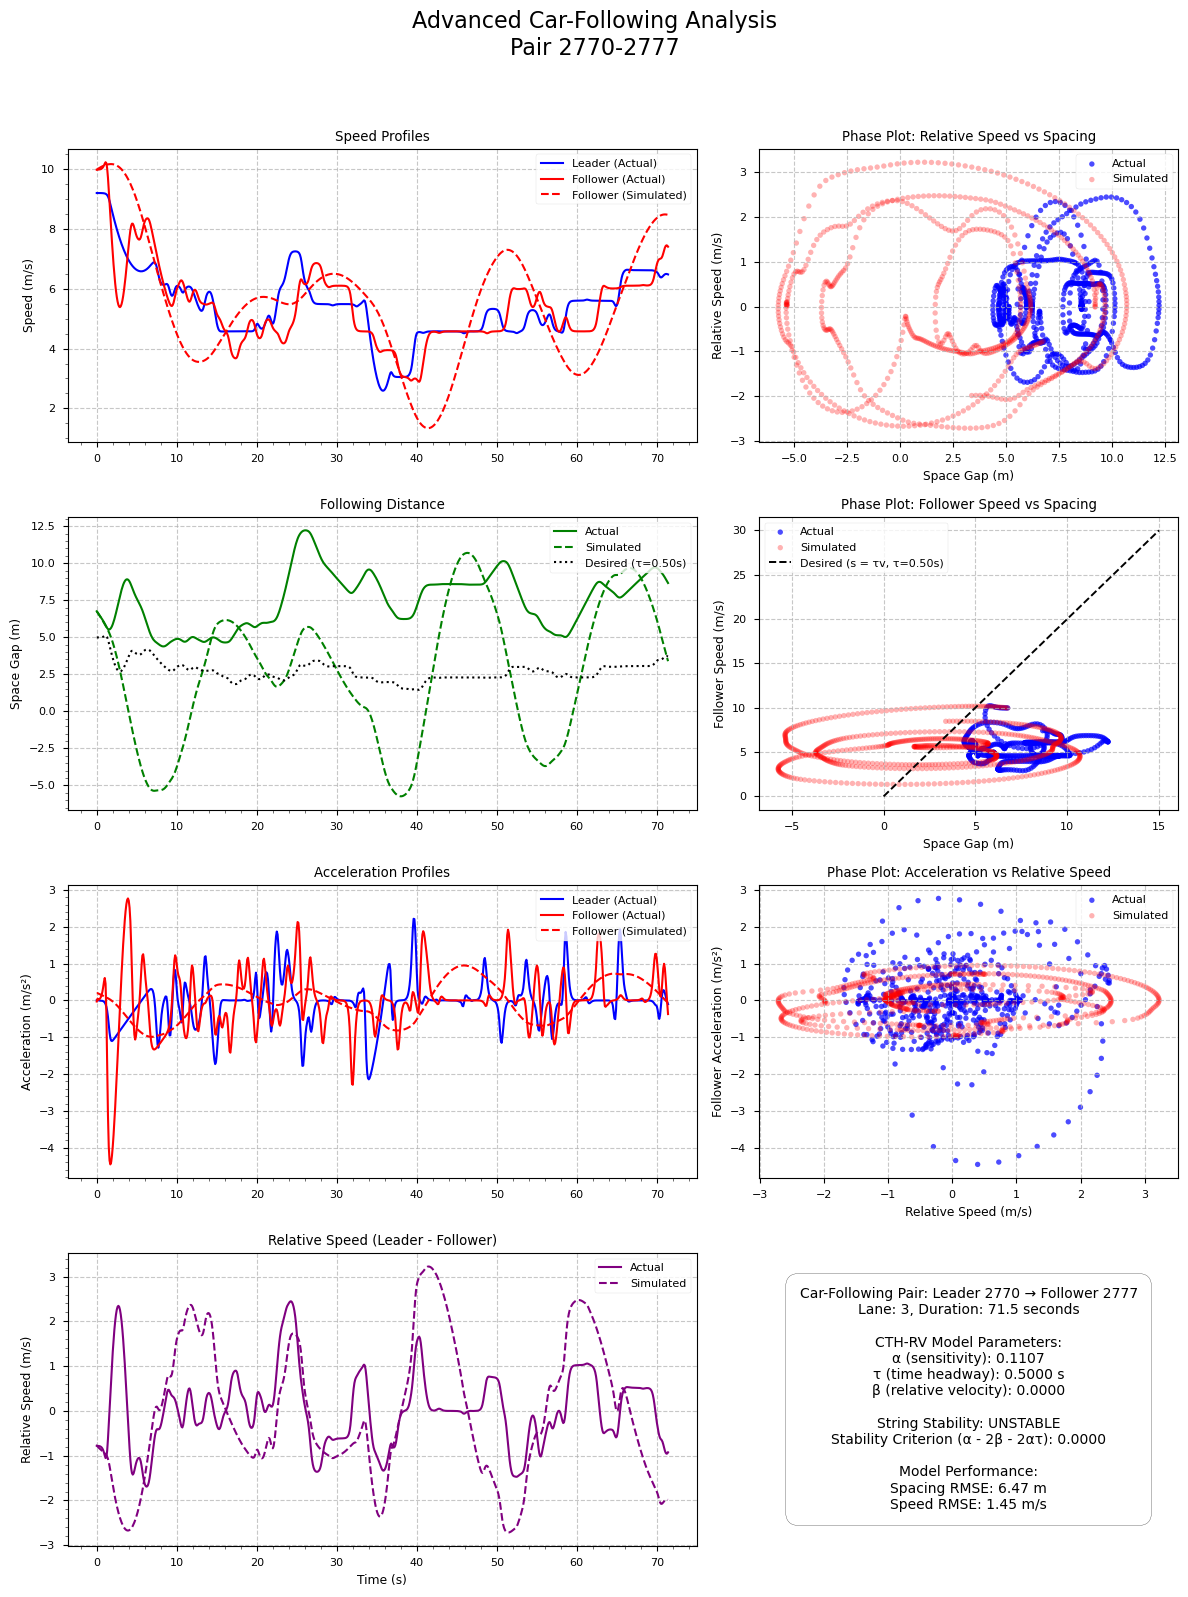

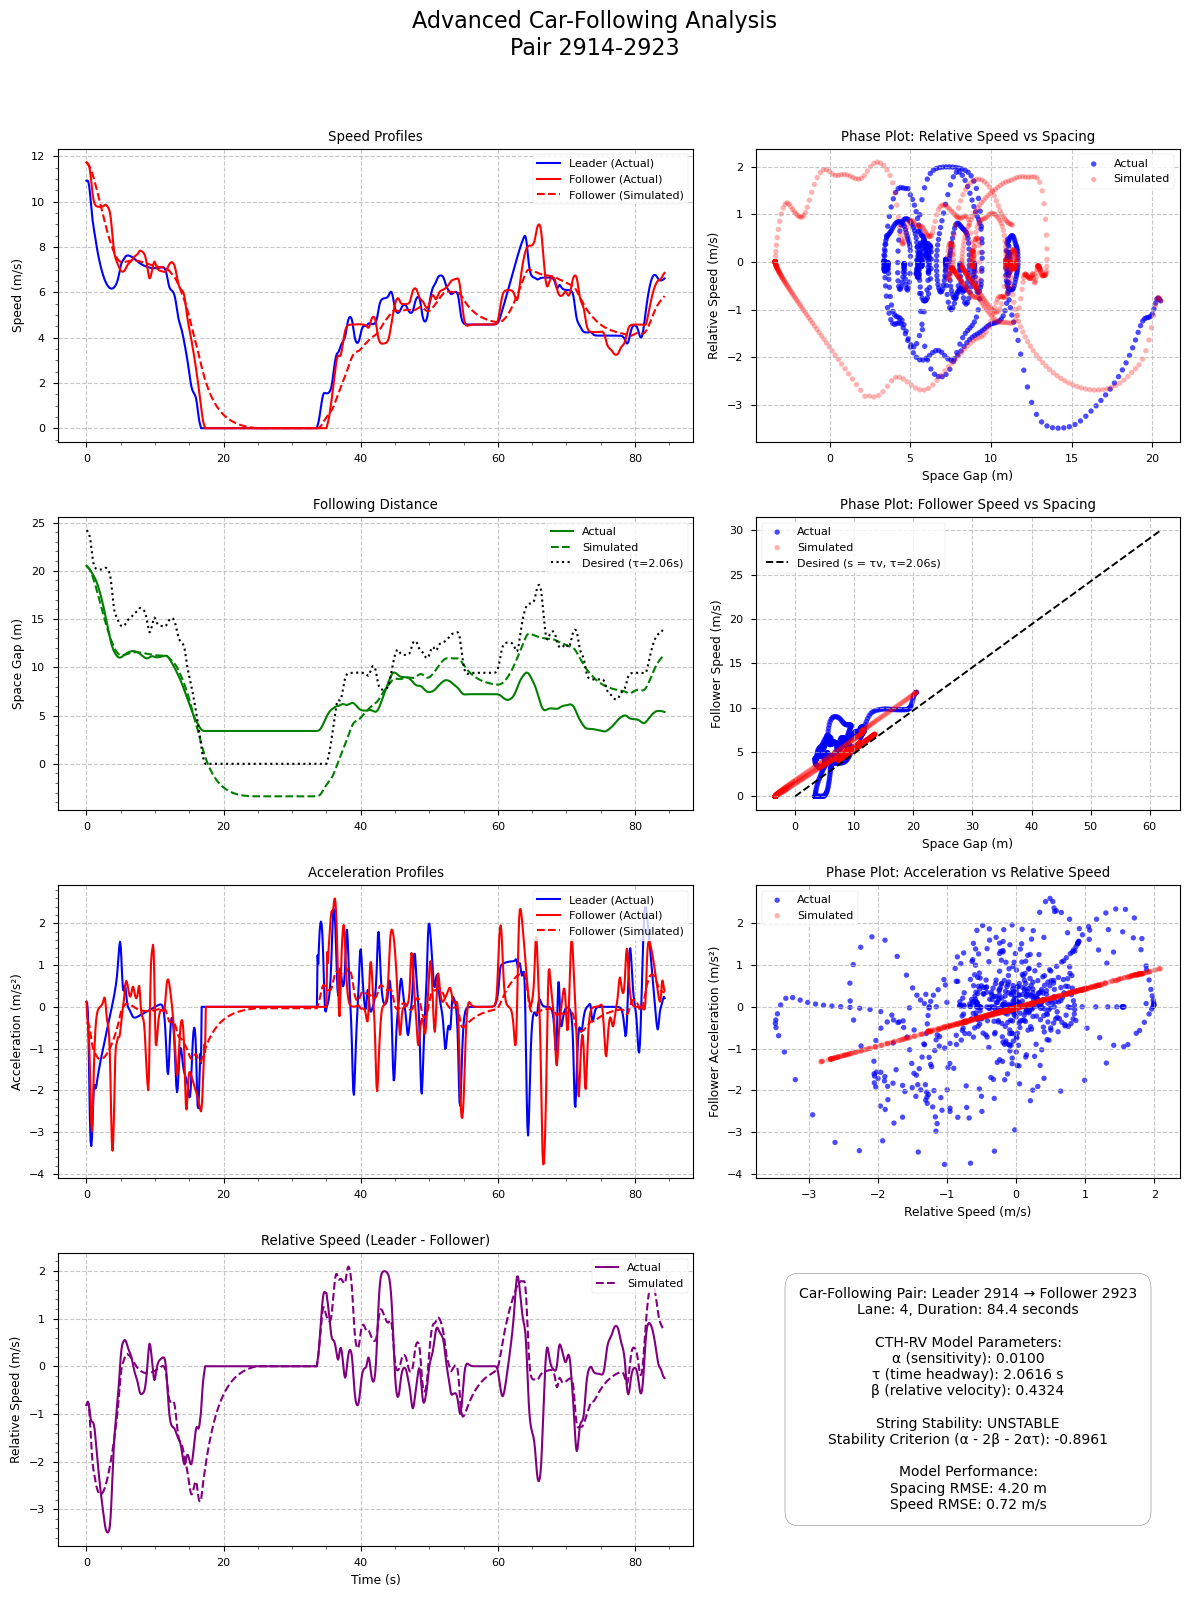

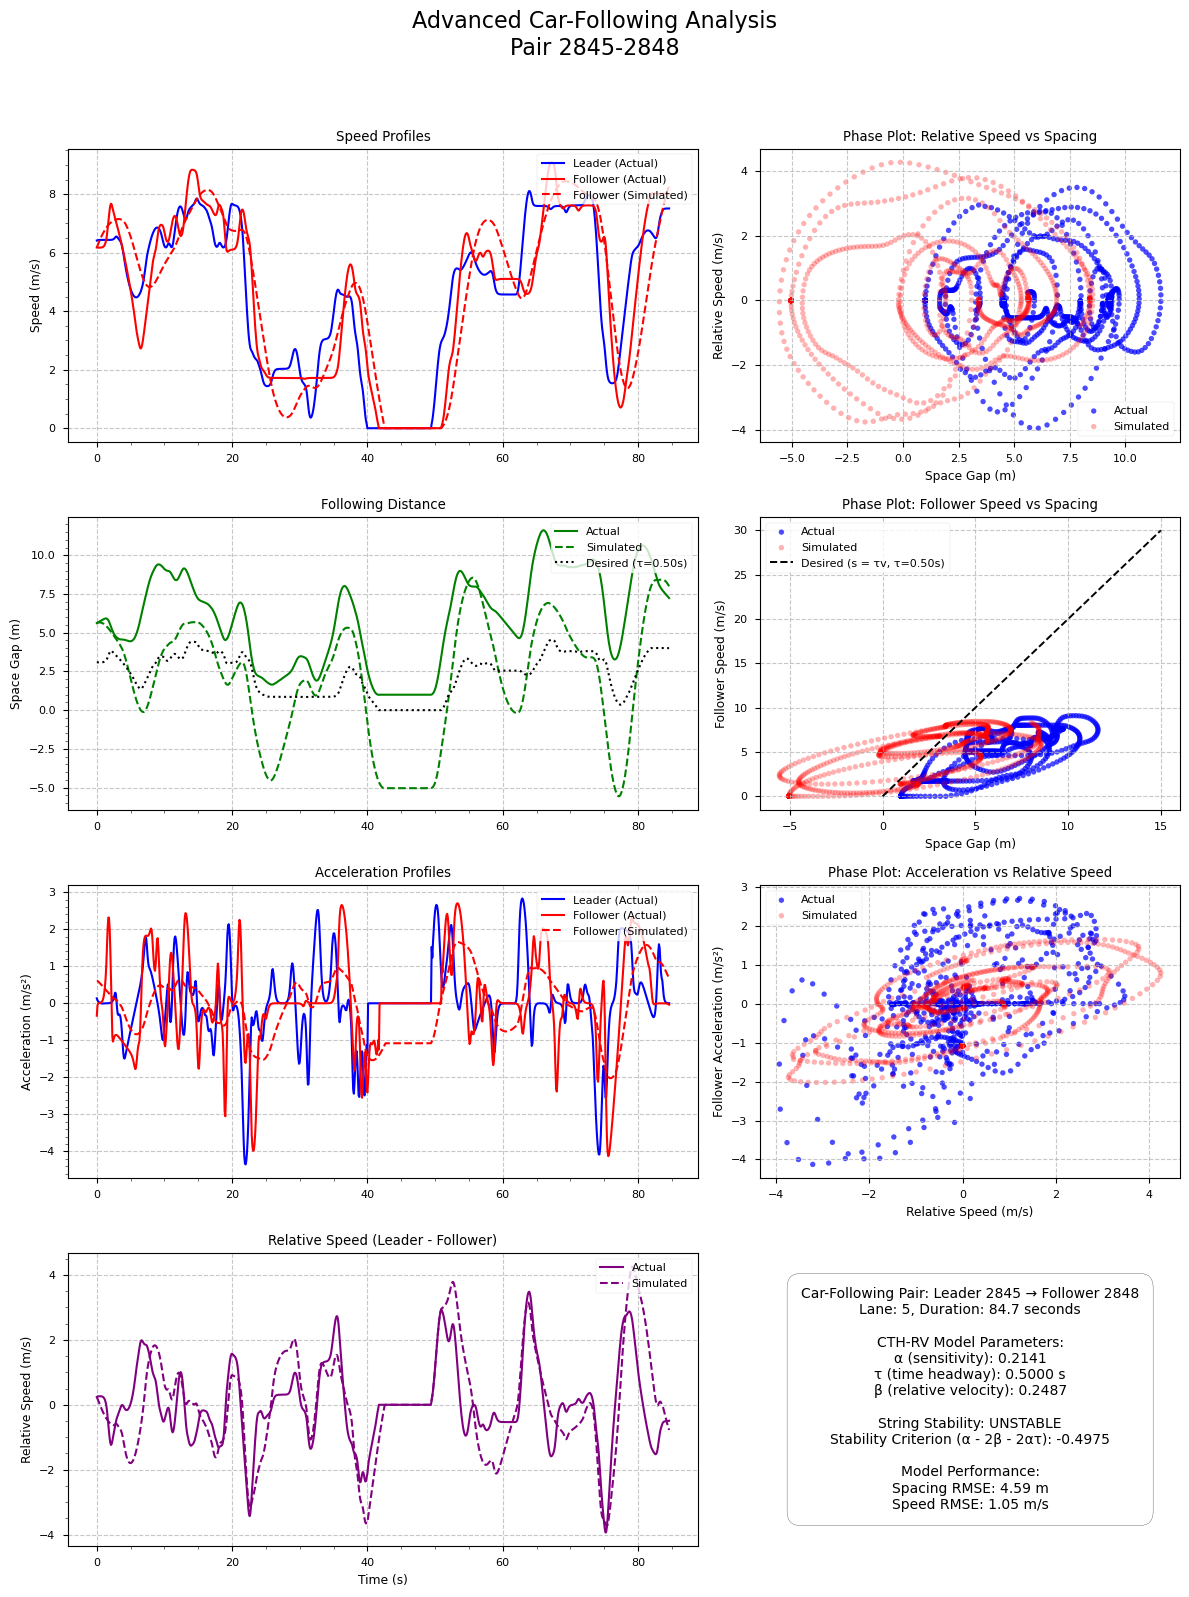

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import splev, splrep
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import logging

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

@dataclass
class CarFollowingPair:
    """Represents a validated car-following pair with all relevant information"""
    leader_id: int
    follower_id: int
    start_frame: int
    end_frame: int
    lane_id: int
    metrics: Dict = None
    
    @property
    def duration(self) -> float:
        """Duration of car-following episode in seconds"""
        return (self.end_frame - self.start_frame + 1) * 0.1  # Convert frames to seconds

def load_data(file_path):
    """Load and process the trajectory data"""
    try:
        # Read data with numbered columns first
        data = pd.read_csv(file_path, delimiter=r'\s+', header=None)
        
        # Rename columns to match expected format
        data.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'Local_Y', 
                       'Speed', 'Acceleration', 'Vehicle_Length',
                       'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        logger.info(f"Successfully loaded data with {len(data)} rows")
        return data
        
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def find_car_following_pairs(data):
    """Identify car-following pairs that persist for at least 20 seconds"""
    pairs = []
    min_duration = 200  # 20 seconds (at 0.1s intervals)
    
    # Process each vehicle
    for vehicle_id in data['Vehicle_ID'].unique():
        vehicle_data = data[data['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
        
        # Find unique leaders (excluding -1 which indicates no leader)
        leaders = vehicle_data['Leader_ID'].unique()
        leaders = leaders[leaders != -1]
        
        for leader_id in leaders:
            # Get frames where this vehicle follows the current leader
            following_frames = vehicle_data[vehicle_data['Leader_ID'] == leader_id]['Frame_ID']
            
            if len(following_frames) >= min_duration:
                # Create car following pair
                start_frame = following_frames.iloc[0]
                end_frame = following_frames.iloc[-1]
                lane_id = vehicle_data['Lane_ID'].iloc[0]
                
                pair = CarFollowingPair(
                    leader_id=leader_id,
                    follower_id=vehicle_id,
                    start_frame=start_frame,
                    end_frame=end_frame,
                    lane_id=lane_id
                )
                pairs.append(pair)
    
    logger.info(f"Found {len(pairs)} car-following pairs")
    return pairs

def process_pair_data(data, pair: CarFollowingPair):
    """Process data for a car-following pair with advanced metrics"""
    # Get trajectory data for leader and follower
    frames = range(int(pair.start_frame), int(pair.end_frame) + 1)
    
    leader_data = data[
        (data['Vehicle_ID'] == pair.leader_id) & 
        (data['Frame_ID'].isin(frames))
    ].sort_values('Frame_ID')
    
    follower_data = data[
        (data['Vehicle_ID'] == pair.follower_id) & 
        (data['Frame_ID'].isin(frames))
    ].sort_values('Frame_ID')
    
    # Combine data
    merged_data = pd.merge(
        leader_data, 
        follower_data,
        on='Frame_ID',
        suffixes=('_leader', '_follower')
    )
    
    # Calculate time series data
    merged_data['time'] = (merged_data['Frame_ID'] - pair.start_frame) * 0.1
    merged_data['spacing'] = merged_data['Local_Y_leader'] - merged_data['Local_Y_follower'] - leader_data['Vehicle_Length'].iloc[0]
    merged_data['relative_speed'] = merged_data['Speed_leader'] - merged_data['Speed_follower']
    merged_data['time_headway'] = merged_data['spacing'] / merged_data['Speed_follower']
    
    # Calculate derived metrics used in research papers
    # 1. Time-to-collision (TTC)
    # TTC is defined as spacing/(-relative_speed) when relative_speed < 0
    merged_data['ttc'] = np.where(
        merged_data['relative_speed'] < 0,
        -merged_data['spacing'] / merged_data['relative_speed'],
        np.inf
    )
    
    # 2. Modified time-to-collision (MTTC) - includes reaction time
    reaction_time = 1.0  # 1 second reaction time (common in research)
    merged_data['mttc'] = np.where(
        merged_data['relative_speed'] < 0,
        (-merged_data['spacing'] + reaction_time * merged_data['Speed_follower']) / merged_data['relative_speed'],
        np.inf
    )
    
    # Replace infinite values with NaN for plotting
    merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Smooth the data using spline interpolation for better visualization
    # This follows practices in research papers that attempt to reduce noise
    def smooth_series(series, s=0.5):
        x = np.arange(len(series))
        
        # Filter out infinite and NaN values
        mask = np.isfinite(series)
        if sum(mask) < 4:  # Need at least 4 points for cubic spline
            return series
            
        x_valid = x[mask]
        y_valid = series[mask]
        
        if len(x_valid) < len(x):
            # Create spline with only valid data
            spline = splrep(x_valid, y_valid, s=s)
            # Evaluate for all points
            return splev(x, spline)
        else:
            spline = splrep(x, series, s=s)
            return splev(x, spline)
    
    # Apply smoothing to relevant columns
    smoothed_data = merged_data.copy()
    for col in ['Speed_leader', 'Speed_follower', 'spacing', 'relative_speed', 'Acceleration_leader', 'Acceleration_follower']:
        if col in smoothed_data.columns:
            smoothed_data[f'{col}_smooth'] = smooth_series(smoothed_data[col].values)
    
    # Calculate additional metrics used in the CTH-RV model calibration
    smoothed_data['desired_spacing'] = np.nan  # Will be filled after model calibration
    
    return merged_data, smoothed_data

def calibrate_cth_rv_model(data: pd.DataFrame) -> Tuple[float, float, float]:
    """
    Calibrates the Constant-Time-Headway Relative-Velocity (CTH-RV) model
    
    The model is: dv/dt = α(s - τv) + β(v_leader - v_follower)
    
    Returns:
    α, τ, β: Model parameters
    """
    # Extract necessary data
    spacing = data['spacing'].values
    follower_speed = data['Speed_follower'].values
    relative_speed = data['relative_speed'].values
    follower_accel = data['Acceleration_follower'].values
    
    # Simple calibration using least squares regression
    # This estimates α, τ, β to minimize error in predicted acceleration
    X = np.column_stack([
        spacing,  # For α
        -follower_speed,  # For -ατ
        relative_speed  # For β
    ])
    
    # Remove any rows with NaN values
    valid_rows = ~np.isnan(X).any(axis=1) & ~np.isnan(follower_accel)
    X = X[valid_rows]
    y = follower_accel[valid_rows]
    
    if len(X) < 3:
        logger.warning("Not enough valid data points for calibration")
        return 0.1, 1.5, 0.2  # Default values
    
    # Solve for the parameters
    try:
        params, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
        alpha = params[0]
        tau = -params[1] / alpha if alpha != 0 else 1.5
        beta = params[2]
        
        # Make sure parameters are physically reasonable
        alpha = max(0.01, min(alpha, 2.0))  # Bound between 0.01 and 2.0
        tau = max(0.5, min(tau, 3.0))       # Bound between 0.5 and 3.0 seconds
        beta = max(0.0, min(beta, 1.0))     # Bound between 0.0 and 1.0
        
        return alpha, tau, beta
        
    except Exception as e:
        logger.error(f"Error in calibration: {e}")
        return 0.1, 1.5, 0.2  # Default values

def evaluate_string_stability(alpha: float, tau: float, beta: float) -> Tuple[bool, float]:
    """
    Evaluates string stability of the calibrated CTH-RV model
    based on the criteria from traffic flow theory.
    
    Returns:
    is_stable: Boolean indicating if the system is string stable
    stability_margin: How close to the stability boundary
    """
    # String stability criterion for CTH-RV model:
    # α - 2β - 2ατ > 0
    
    stability_criterion = alpha - 2*beta - 2*alpha*tau
    is_stable = stability_criterion > 0
    
    # Return the result and the margin
    return is_stable, stability_criterion

def simulate_cth_rv_model(data: pd.DataFrame, alpha: float, tau: float, beta: float) -> pd.DataFrame:
    """
    Simulates the car-following behavior using the calibrated CTH-RV model
    
    The model is: dv/dt = α(s - τv) + β(v_leader - v_follower)
    
    Returns:
    DataFrame with simulated trajectories
    """
    # Create DataFrame for simulation results
    sim_data = data.copy()
    
    # We'll start the simulation with the actual initial conditions
    sim_speed = [sim_data['Speed_follower'].iloc[0]]
    sim_position = [sim_data['Local_Y_follower'].iloc[0]]
    sim_spacing = [sim_data['spacing'].iloc[0]]
    sim_accel = [alpha * (sim_spacing[0] - tau * sim_speed[0]) + 
                 beta * (sim_data['Speed_leader'].iloc[0] - sim_speed[0])]
    
    # Time step (0.1 seconds)
    dt = 0.1
    
    # Simulate using leader's actual trajectory
    for i in range(1, len(sim_data)):
        # Get leader speed at this time step
        leader_speed = sim_data['Speed_leader'].iloc[i]
        leader_position = sim_data['Local_Y_leader'].iloc[i]
        
        # Update follower speed and position using the model
        new_accel = alpha * (sim_spacing[i-1] - tau * sim_speed[i-1]) + \
                    beta * (leader_speed - sim_speed[i-1])
        
        # Bound acceleration to realistic limits (-4 to 2 m/s^2)
        new_accel = max(-4.0, min(new_accel, 2.0))
        
        # Update speed
        new_speed = sim_speed[i-1] + new_accel * dt
        
        # Ensure speed stays positive
        new_speed = max(0.0, new_speed)
        
        # Update position
        new_position = sim_position[i-1] + new_speed * dt
        
        # Calculate new spacing
        new_spacing = leader_position - new_position - sim_data['Vehicle_Length_leader'].iloc[0]
        
        # Add to lists
        sim_accel.append(new_accel)
        sim_speed.append(new_speed)
        sim_position.append(new_position)
        sim_spacing.append(new_spacing)
    
    # Add simulated data to the DataFrame
    sim_data['sim_accel'] = sim_accel
    sim_data['sim_speed'] = sim_speed
    sim_data['sim_position'] = sim_position
    sim_data['sim_spacing'] = sim_spacing
    sim_data['desired_spacing'] = tau * sim_data['Speed_follower']
    
    return sim_data

def plot_advanced_pair_visualization(pair: CarFollowingPair, raw_data: pd.DataFrame, 
                                    sim_data: pd.DataFrame, alpha: float, tau: float, 
                                    beta: float, is_stable: bool, 
                                    filename: str = None):
    """
    Creates a comprehensive car-following visualization based on research paper standards
    """
    # Create a figure with GridSpec for flexible layout
    fig = plt.figure(figsize=(12, 16))
    gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1.5, 1])
    
    # Set the style to match academic publications
    plt.style.use('seaborn-v0_8-paper')
    
    # Create axes
    ax_speed = fig.add_subplot(gs[0, 0])
    ax_spacing = fig.add_subplot(gs[1, 0])
    ax_accel = fig.add_subplot(gs[2, 0])
    ax_rel_speed = fig.add_subplot(gs[3, 0])
    
    # Phase plots used in research papers
    ax_phase1 = fig.add_subplot(gs[0, 1])
    ax_phase2 = fig.add_subplot(gs[1, 1])
    ax_phase3 = fig.add_subplot(gs[2, 1])
    
    # Calibration & stability info
    ax_info = fig.add_subplot(gs[3, 1])
    ax_info.axis('off')  # No axes for text information
    
    # Common time axis
    time = raw_data['time']
    
    # 1. Speed Profiles
    ax_speed.plot(time, raw_data['Speed_leader'], 'b-', label='Leader (Actual)', linewidth=1.5)
    ax_speed.plot(time, raw_data['Speed_follower'], 'r-', label='Follower (Actual)', linewidth=1.5)
    if 'sim_speed' in sim_data.columns:
        ax_speed.plot(time, sim_data['sim_speed'], 'r--', label='Follower (Simulated)', linewidth=1.5)
    ax_speed.set_ylabel('Speed (m/s)')
    ax_speed.set_title('Speed Profiles')
    ax_speed.grid(True, linestyle='--', alpha=0.7)
    ax_speed.legend(loc='upper right')
    ax_speed.xaxis.set_minor_locator(AutoMinorLocator())
    ax_speed.yaxis.set_minor_locator(AutoMinorLocator())
    
    # 2. Space Gap
    ax_spacing.plot(time, raw_data['spacing'], 'g-', label='Actual', linewidth=1.5)
    if 'sim_spacing' in sim_data.columns:
        ax_spacing.plot(time, sim_data['sim_spacing'], 'g--', label='Simulated', linewidth=1.5)
    if 'desired_spacing' in sim_data.columns:
        ax_spacing.plot(time, sim_data['desired_spacing'], 'k:', label=f'Desired (τ={tau:.2f}s)', linewidth=1.5)
    ax_spacing.set_ylabel('Space Gap (m)')
    ax_spacing.set_title('Following Distance')
    ax_spacing.grid(True, linestyle='--', alpha=0.7)
    ax_spacing.legend(loc='upper right')
    ax_spacing.xaxis.set_minor_locator(AutoMinorLocator())
    ax_spacing.yaxis.set_minor_locator(AutoMinorLocator())
    
    # 3. Acceleration Profiles
    ax_accel.plot(time, raw_data['Acceleration_leader'], 'b-', label='Leader (Actual)', linewidth=1.5)
    ax_accel.plot(time, raw_data['Acceleration_follower'], 'r-', label='Follower (Actual)', linewidth=1.5)
    if 'sim_accel' in sim_data.columns:
        ax_accel.plot(time, sim_data['sim_accel'], 'r--', label='Follower (Simulated)', linewidth=1.5)
    ax_accel.set_ylabel('Acceleration (m/s²)')
    ax_accel.set_title('Acceleration Profiles')
    ax_accel.grid(True, linestyle='--', alpha=0.7)
    ax_accel.legend(loc='upper right')
    ax_accel.xaxis.set_minor_locator(AutoMinorLocator())
    ax_accel.yaxis.set_minor_locator(AutoMinorLocator())
    
    # 4. Relative Speed
    ax_rel_speed.plot(time, raw_data['relative_speed'], 'purple', label='Actual', linewidth=1.5)
    if 'sim_speed' in sim_data.columns:
        leader_speed = raw_data['Speed_leader']
        sim_rel_speed = leader_speed - sim_data['sim_speed']
        ax_rel_speed.plot(time, sim_rel_speed, 'purple', linestyle='--', label='Simulated', linewidth=1.5)
    ax_rel_speed.set_ylabel('Relative Speed (m/s)')
    ax_rel_speed.set_xlabel('Time (s)')
    ax_rel_speed.set_title('Relative Speed (Leader - Follower)')
    ax_rel_speed.grid(True, linestyle='--', alpha=0.7)
    ax_rel_speed.legend(loc='upper right')
    ax_rel_speed.xaxis.set_minor_locator(AutoMinorLocator())
    ax_rel_speed.yaxis.set_minor_locator(AutoMinorLocator())
    
    # 5. Phase Plot 1: Relative Speed vs Spacing (Common in CF research)
    ax_phase1.scatter(raw_data['spacing'], raw_data['relative_speed'], 
                     s=15, color='blue', alpha=0.7, edgecolor='none', label='Actual')
    if 'sim_spacing' in sim_data.columns:
        ax_phase1.scatter(sim_data['sim_spacing'], sim_rel_speed, 
                        s=15, color='red', alpha=0.3, edgecolor='none', label='Simulated')
    ax_phase1.set_xlabel('Space Gap (m)')
    ax_phase1.set_ylabel('Relative Speed (m/s)')
    ax_phase1.set_title('Phase Plot: Relative Speed vs Spacing')
    ax_phase1.grid(True, linestyle='--', alpha=0.7)
    ax_phase1.legend(loc='best')
    
    # 6. Phase Plot 2: Follower Speed vs Spacing (Used for steady-state analysis)
    ax_phase2.scatter(raw_data['spacing'], raw_data['Speed_follower'], 
                     s=15, color='blue', alpha=0.7, edgecolor='none', label='Actual')
    if 'sim_spacing' in sim_data.columns:
        ax_phase2.scatter(sim_data['sim_spacing'], sim_data['sim_speed'], 
                        s=15, color='red', alpha=0.3, edgecolor='none', label='Simulated')
    
    # Add desired spacing line (s = τv)
    speed_range = np.linspace(min(raw_data['Speed_follower'].min(), 0), 
                              max(raw_data['Speed_follower'].max(), 30), 100)
    ax_phase2.plot(tau * speed_range, speed_range, 'k--', 
                  label=f'Desired (s = τv, τ={tau:.2f}s)')
    
    ax_phase2.set_xlabel('Space Gap (m)')
    ax_phase2.set_ylabel('Follower Speed (m/s)')
    ax_phase2.set_title('Phase Plot: Follower Speed vs Spacing')
    ax_phase2.grid(True, linestyle='--', alpha=0.7)
    ax_phase2.legend(loc='best')
    
    # 7. Phase Plot 3: Acceleration vs Relative Speed (Shows control strategy)
    ax_phase3.scatter(raw_data['relative_speed'], raw_data['Acceleration_follower'], 
                     s=15, color='blue', alpha=0.7, edgecolor='none', label='Actual')
    if 'sim_accel' in sim_data.columns:
        ax_phase3.scatter(sim_rel_speed, sim_data['sim_accel'], 
                        s=15, color='red', alpha=0.3, edgecolor='none', label='Simulated')
    ax_phase3.set_xlabel('Relative Speed (m/s)')
    ax_phase3.set_ylabel('Follower Acceleration (m/s²)')
    ax_phase3.set_title('Phase Plot: Acceleration vs Relative Speed')
    ax_phase3.grid(True, linestyle='--', alpha=0.7)
    ax_phase3.legend(loc='best')
    
    # 8. Model Calibration & Stability Information
    # Calculate error metrics
    if 'sim_spacing' in sim_data.columns:
        spacing_rmse = np.sqrt(np.mean((raw_data['spacing'] - sim_data['sim_spacing'])**2))
        speed_rmse = np.sqrt(np.mean((raw_data['Speed_follower'] - sim_data['sim_speed'])**2))
        
        info_text = (
            f"Car-Following Pair: Leader {pair.leader_id} → Follower {pair.follower_id}\n"
            f"Lane: {pair.lane_id}, Duration: {pair.duration:.1f} seconds\n\n"
            f"CTH-RV Model Parameters:\n"
            f"α (sensitivity): {alpha:.4f}\n"
            f"τ (time headway): {tau:.4f} s\n"
            f"β (relative velocity): {beta:.4f}\n\n"
            f"String Stability: {'STABLE' if is_stable else 'UNSTABLE'}\n"
            f"Stability Criterion (α - 2β - 2ατ): {alpha - 2*beta - 2*alpha*tau:.4f}\n\n"
            f"Model Performance:\n"
            f"Spacing RMSE: {spacing_rmse:.2f} m\n"
            f"Speed RMSE: {speed_rmse:.2f} m/s"
        )
    else:
        info_text = (
            f"Car-Following Pair: Leader {pair.leader_id} → Follower {pair.follower_id}\n"
            f"Lane: {pair.lane_id}, Duration: {pair.duration:.1f} seconds\n\n"
            f"Metrics:\n"
            f"Mean Spacing: {raw_data['spacing'].mean():.2f} m\n"
            f"Mean Time Headway: {(raw_data['spacing'] / raw_data['Speed_follower']).mean():.2f} s\n"
            f"Mean Relative Speed: {raw_data['relative_speed'].mean():.2f} m/s\n"
        )
    
    ax_info.text(0.5, 0.5, info_text, 
                horizontalalignment='center', 
                verticalalignment='center',
                transform=ax_info.transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1'))
    
    # Set title for the entire figure
    fig.suptitle(f"Advanced Car-Following Analysis\nPair {pair.leader_id}-{pair.follower_id}", 
                fontsize=16, y=0.995)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure if filename provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        logger.info(f"Saved visualization to {filename}")
    
    return fig

def analyze_car_following_pair(pair: CarFollowingPair, data: pd.DataFrame):
    """Comprehensive analysis of a single car-following pair"""
    # Process the pair data
    raw_data, smoothed_data = process_pair_data(data, pair)
    
    # Calibrate the CTH-RV model
    alpha, tau, beta = calibrate_cth_rv_model(raw_data)
    logger.info(f"Calibrated CTH-RV model for pair {pair.leader_id}-{pair.follower_id}: "
               f"α={alpha:.4f}, τ={tau:.4f}, β={beta:.4f}")
    
    # Evaluate string stability
    is_stable, stability_criterion = evaluate_string_stability(alpha, tau, beta)
    stability_status = "STABLE" if is_stable else "UNSTABLE"
    logger.info(f"String stability for pair {pair.leader_id}-{pair.follower_id}: {stability_status} "
               f"(criterion value: {stability_criterion:.4f})")
    
    # Simulate the model
    sim_data = simulate_cth_rv_model(raw_data, alpha, tau, beta)
    
    # Create visualization
    filename = f"advanced_pair_{pair.leader_id}_{pair.follower_id}_analysis.png"
    fig = plot_advanced_pair_visualization(
        pair, raw_data, sim_data, 
        alpha, tau, beta, is_stable,
        filename
    )
    
    # Return the analysis results
    return {
        'pair': pair,
        'raw_data': raw_data,
        'sim_data': sim_data,
        'parameters': {
            'alpha': alpha,
            'tau': tau,
            'beta': beta
        },
        'stability': {
            'is_stable': is_stable,
            'criterion': stability_criterion
        }
    }

def main():
    # Load data
    logger.info("Loading data...")
    data = load_data("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA (NO MOTORCYCLES).txt")
    
    if len(data) == 0:
        logger.error("Failed to load data")
        return
        
    # Find car-following pairs
    logger.info("Finding car-following pairs...")
    pairs = find_car_following_pairs(data)
    
    if len(pairs) == 0:
        logger.error("No car-following pairs found")
        return
        
    # Select sample pairs from different lanes for diversity
    # This approach gives more insight than just taking the first 5 pairs
    lane_pairs = {}
    for pair in pairs:
        if pair.lane_id not in lane_pairs:
            lane_pairs[pair.lane_id] = []
        lane_pairs[pair.lane_id].append(pair)
    
    # Select one pair from each lane, up to 5 pairs
    selected_pairs = []
    for lane_id in sorted(lane_pairs.keys()):
        if len(selected_pairs) < 5 and lane_pairs[lane_id]:
            # Choose the longest duration pair from this lane
            lane_pairs[lane_id].sort(key=lambda p: p.duration, reverse=True)
            selected_pairs.append(lane_pairs[lane_id][0])
    
    # If we still have fewer than 5 pairs, add more from the most populated lanes
    all_pairs = []
    for lane_id in sorted(lane_pairs.keys(), key=lambda k: len(lane_pairs[k]), reverse=True):
        all_pairs.extend(lane_pairs[lane_id])
        if len(selected_pairs) + len(all_pairs) >= 5:
            break
    
    while len(selected_pairs) < 5 and all_pairs:
        selected_pairs.append(all_pairs.pop(0))
    
    # Analyze each selected pair
    logger.info(f"Analyzing {len(selected_pairs)} selected car-following pairs...")
    all_results = []
    
    for pair in selected_pairs:
        logger.info(f"Analyzing pair {pair.leader_id}-{pair.follower_id} in lane {pair.lane_id}...")
        results = analyze_car_following_pair(pair, data)
        all_results.append(results)
    
    # Create summary of results
    summary = pd.DataFrame([{
        'leader_id': r['pair'].leader_id,
        'follower_id': r['pair'].follower_id,
        'lane_id': r['pair'].lane_id,
        'duration': r['pair'].duration,
        'alpha': r['parameters']['alpha'],
        'tau': r['parameters']['tau'],
        'beta': r['parameters']['beta'],
        'is_stable': r['stability']['is_stable'],
        'stability_criterion': r['stability']['criterion'],
        'mean_spacing': r['raw_data']['spacing'].mean(),
        'mean_time_headway': (r['raw_data']['spacing'] / r['raw_data']['Speed_follower']).mean(),
        'mean_speed': r['raw_data']['Speed_follower'].mean(),
        'spacing_rmse': np.sqrt(np.mean((r['raw_data']['spacing'] - r['sim_data']['sim_spacing'])**2)),
        'speed_rmse': np.sqrt(np.mean((r['raw_data']['Speed_follower'] - r['sim_data']['sim_speed'])**2))
    } for r in all_results])
    
    # Save summary to CSV
    summary.to_csv('car_following_analysis_summary.csv', index=False)
    logger.info("Analysis complete! Results saved to car_following_analysis_summary.csv")
    
    return all_results

if __name__ == "__main__":
    main()

Calibrate

The following code uses the car_following_pairs.csv

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from typing import List, Tuple, Dict
import seaborn as sns
from dataclasses import dataclass

@dataclass
class CarFollowingPair:
    """Represents a car-following pair with trajectory data"""
    leader_id: int
    follower_id: int
    times: np.ndarray
    leader_speeds: np.ndarray
    follower_speeds: np.ndarray
    spacings: np.ndarray

def load_ngsim_data(file_path: str) -> pd.DataFrame:
    """Load and preprocess NGSIM trajectory data"""
    # Read the data with specific column names
    df = pd.read_csv(file_path, delimiter=r'\s+', header=None)
    df.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                 'Speed', 'Acceleration', 'Vehicle_Length',
                 'Vehicle_Class', 'Follower_ID', 'Leader_ID']
    
    # Convert Frame_ID to time in seconds
    df['Time'] = df['Frame_ID'] * 0.1
    
    return df

def load_car_following_pairs_from_csv(csv_path: str, num_pairs: int = 5) -> List[dict]:
    """
    Load previously identified car-following pairs from a CSV file
    
    Parameters:
    csv_path: Path to the CSV file with car-following pairs
    num_pairs: Number of pairs to load (default: 5)
    
    Returns:
    List of dictionaries with car-following pair information
    """
    try:
        pairs_df = pd.read_csv(csv_path)
        print(f"Loaded {len(pairs_df)} car-following pairs from {csv_path}")
        
        # Select the specified number of pairs
        selected_df = pairs_df.head(num_pairs)
        
        # Convert to list of dictionaries
        pairs = []
        for _, row in selected_df.iterrows():
            pairs.append({
                'leader_id': row['leader_id'],
                'follower_id': row['follower_id'],
                'start_frame': row['start_frame'],
                'end_frame': row['end_frame'],
                'lane_id': row['lane_id'] if 'lane_id' in row else row.get('lane', 1)
            })
        
        print(f"Selected {len(pairs)} pairs for analysis")
        return pairs
    
    except Exception as e:
        print(f"Error loading car-following pairs: {e}")
        return []

def prepare_pairs_for_calibration(df: pd.DataFrame, pair_info: List[dict]) -> List[CarFollowingPair]:
    """
    Prepare car-following pairs for calibration by extracting trajectory data
    
    Parameters:
    df: DataFrame containing trajectory data
    pair_info: List of dictionaries with pair information from CSV
    
    Returns:
    List of CarFollowingPair objects with trajectory data
    """
    calibration_pairs = []
    
    for pair in pair_info:
        # Get frame range
        frames = range(int(pair['start_frame']), int(pair['end_frame']) + 1)
        
        # Extract trajectory data for leader and follower
        leader_data = df[(df['Vehicle_ID'] == pair['leader_id']) & 
                        (df['Frame_ID'].isin(frames))].sort_values('Frame_ID')
        
        follower_data = df[(df['Vehicle_ID'] == pair['follower_id']) & 
                          (df['Frame_ID'].isin(frames))].sort_values('Frame_ID')
        
        # Find common frames (may be needed if there are any mismatches)
        common_frames = np.intersect1d(leader_data['Frame_ID'], follower_data['Frame_ID'])
        
        # Filter to common frames
        leader_data = leader_data[leader_data['Frame_ID'].isin(common_frames)]
        follower_data = follower_data[follower_data['Frame_ID'].isin(common_frames)]
        
        # Check if we have sufficient data
        if len(leader_data) < 10 or len(follower_data) < 10:
            print(f"Warning: Insufficient data for pair {pair['leader_id']}-{pair['follower_id']}, skipping")
            continue
        
        # Create CarFollowingPair object
        calibration_pair = CarFollowingPair(
            leader_id=pair['leader_id'],
            follower_id=pair['follower_id'],
            times=leader_data['Time'].values,
            leader_speeds=leader_data['Speed'].values,
            follower_speeds=follower_data['Speed'].values,
            spacings=leader_data['LocalY'].values - follower_data['LocalY'].values
        )
        
        calibration_pairs.append(calibration_pair)
    
    return calibration_pairs

class CTHRV_Model:
    """Implements the Constant Time Headway Relative Velocity (CTH-RV) car-following model"""
    
    def __init__(self, dt: float = 0.1):
        self.dt = dt
    
    def simulate(self, 
                initial_spacing: float,
                initial_follower_speed: float,
                leader_speeds: np.ndarray,
                params: Tuple[float, float, float]) -> Tuple[np.ndarray, np.ndarray]:
        """Simulate vehicle trajectory using the CTH-RV model"""
        α, T, β = params
        
        n_steps = len(leader_speeds)
        speeds = np.zeros(n_steps)
        spacings = np.zeros(n_steps)
        
        speeds[0] = initial_follower_speed
        spacings[0] = initial_spacing
        
        for t in range(1, n_steps):
            # Calculate relative velocity
            v_rel = leader_speeds[t-1] - speeds[t-1]
            
            # Calculate desired spacing based on current speed
            s_star = T * speeds[t-1]
            
            # Calculate acceleration using CTH-RV model
            acc = α * (spacings[t-1] - s_star) + β * v_rel
            
            # Update speed and position using Euler integration
            speeds[t] = max(0, speeds[t-1] + acc * self.dt)
            spacings[t] = spacings[t-1] + (leader_speeds[t-1] - speeds[t-1]) * self.dt
        
        return speeds, spacings

    def calibrate(self, 
                 pair: CarFollowingPair,
                 bounds: Dict[str, Tuple[float, float]] = None) -> Tuple[Tuple[float, float, float], float]:
        """Calibrate model parameters using differential evolution"""
        if bounds is None:
            bounds = {
                'α': (0.1, 2.0),    # Sensitivity parameter
                'T': (0.5, 3.0),    # Desired time headway
                'β': (0.1, 1.0)     # Relative velocity parameter
            }
        
        def objective(params: np.ndarray) -> float:
            sim_speeds, sim_spacings = self.simulate(
                pair.spacings[0],
                pair.follower_speeds[0],
                pair.leader_speeds,
                params
            )
            
            # Calculate normalized errors
            speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
            spacing_error = np.mean((sim_spacings - pair.spacings)**2)
            
            # Combine errors with equal weights
            total_error = speed_error + spacing_error
            return total_error
        
        result = differential_evolution(
            objective,
            bounds=[(bounds['α'][0], bounds['α'][1]),
                   (bounds['T'][0], bounds['T'][1]),
                   (bounds['β'][0], bounds['β'][1])],
            maxiter=100,
            popsize=20,
            tol=1e-3
        )
        
        return result.x, result.fun

class CalibrationAnalyzer:
    """Analyzes and visualizes calibration results"""
    
    def plot_results(self,
                    pair: CarFollowingPair,
                    model: CTHRV_Model,
                    params: Tuple[float, float, float],
                    title: str = "") -> None:
        """Plot comparison of actual and simulated trajectories"""
        # Simulate with calibrated parameters
        sim_speeds, sim_spacings = model.simulate(
            pair.spacings[0],
            pair.follower_speeds[0],
            pair.leader_speeds,
            params
        )
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f"CTH-RV Model Calibration Results{': ' + title if title else ''}")
        
        # Plot speeds
        ax1.plot(pair.times, pair.leader_speeds, 'b-', label='Leader (Actual)', linewidth=2)
        ax1.plot(pair.times, pair.follower_speeds, 'r-', label='Follower (Actual)', linewidth=2)
        ax1.plot(pair.times, sim_speeds, 'g--', label='Follower (Simulated)', linewidth=2)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Speed (m/s)')
        ax1.legend()
        ax1.grid(True)
        
        # Calculate speed RMSE
        speed_rmse = np.sqrt(np.mean((sim_speeds - pair.follower_speeds)**2))
        
        # Plot spacings
        ax2.plot(pair.times, pair.spacings, 'b-', label='Actual', linewidth=2)
        ax2.plot(pair.times, sim_spacings, 'r--', label='Simulated', linewidth=2)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Spacing (m)')
        ax2.legend()
        ax2.grid(True)
        
        # Calculate spacing RMSE
        spacing_rmse = np.sqrt(np.mean((sim_spacings - pair.spacings)**2))
        
        # Add parameter values and error metrics
        param_text = (
            f'Calibrated Parameters:\n'
            f'α (sensitivity) = {params[0]:.3f}\n'
            f'T (time headway) = {params[1]:.3f} s\n'
            f'β (relative velocity) = {params[2]:.3f}\n\n'
            f'Error Metrics:\n'
            f'Speed RMSE = {speed_rmse:.2f} m/s\n'
            f'Spacing RMSE = {spacing_rmse:.2f} m'
        )
        plt.figtext(0.02, 0.02, param_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'cth_rv_calibration_{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.close()

    def analyze_string_stability(self, params: Tuple[float, float, float]) -> bool:
        """
        Analyze the string stability of the calibrated CTH-RV model
        
        Parameters:
        params: Calibrated parameters (α, T, β)
        
        Returns:
        True if string stable, False otherwise
        """
        α, T, β = params
        
        # Calculate the string stability criterion for CTH-RV
        # The model is string stable if: β^2 - 2αT ≥ 0
        stability_criterion = β**2 - 2*α*T
        
        is_stable = stability_criterion >= 0
        
        # Return stability result
        return is_stable, stability_criterion

    def plot_pareto_analysis(self,
                           pairs: List[CarFollowingPair],
                           model: CTHRV_Model,
                           param_ranges: Dict[str, np.ndarray]) -> None:
        """Create Pareto analysis plots for parameter sensitivity"""
        if not pairs:
            print("Error: No car-following pairs available for Pareto analysis")
            return
            
        α_range = param_ranges['α']
        T_range = param_ranges['T']
        β_fixed = np.mean(param_ranges['β'])
        
        α_grid, T_grid = np.meshgrid(α_range, T_range)
        errors = np.zeros_like(α_grid)
        
        for i in range(len(T_range)):
            for j in range(len(α_range)):
                params = (α_grid[i,j], T_grid[i,j], β_fixed)
                
                total_error = 0
                for pair in pairs:
                    sim_speeds, sim_spacings = model.simulate(
                        pair.spacings[0],
                        pair.follower_speeds[0],
                        pair.leader_speeds,
                        params
                    )
                    
                    speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
                    spacing_error = np.mean((sim_spacings - pair.spacings)**2)
                    total_error += speed_error + spacing_error
                
                errors[i,j] = total_error / len(pairs)
        
        plt.figure(figsize=(10, 8))
        contour = plt.contour(α_grid, T_grid, np.log10(errors), levels=20)
        plt.colorbar(contour, label='log10(Mean Square Error)')
        plt.xlabel('Sensitivity (α)')
        plt.ylabel('Desired Time Headway (T)')
        plt.title('Parameter Sensitivity Analysis\nCTH-RV Model Calibration')
        
        # Add explanation text
        explanation = (
            'Darker regions indicate lower error (better fit)\n'
            'Contour lines show equal error levels\n'
            'Optimal parameters lie in darkest regions'
        )
        plt.figtext(0.02, 0.02, explanation, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.grid(True)
        plt.savefig('cth_rv_pareto_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Define file paths
    trajectory_path = "D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt"
    pairs_csv_path = "car_following_pairs.csv"
    
    # Load NGSIM data
    print("Loading NGSIM data...")
    df = load_ngsim_data(trajectory_path)
    
    # Load car-following pairs from CSV instead of extracting them again
    print(f"Loading car-following pairs from {pairs_csv_path}...")
    pairs_info = load_car_following_pairs_from_csv(pairs_csv_path)
    
    if not pairs_info:
        print("Error: No valid car-following pairs found in CSV")
        return
    
    # Prepare pairs for calibration
    print("Preparing pairs for calibration...")
    calibration_pairs = prepare_pairs_for_calibration(df, pairs_info)
    
    if not calibration_pairs:
        print("Error: Failed to prepare car-following pairs for calibration")
        return
        
    print(f"Successfully prepared {len(calibration_pairs)} car-following pairs for calibration")
    
    # Initialize model and analyzer
    model = CTHRV_Model()
    analyzer = CalibrationAnalyzer()
    
    # Calibrate model for each pair
    print("\nCalibrating CTH-RV model for each pair...")
    calibration_results = []
    stability_results = []
    
    for i, pair in enumerate(calibration_pairs, 1):
        print(f"\nProcessing pair {i}: Leader {pair.leader_id} - Follower {pair.follower_id}")
        params, error = model.calibrate(pair)
        calibration_results.append((params, error))
        
        # Check string stability
        is_stable, stability_value = analyzer.analyze_string_stability(params)
        stability_results.append((is_stable, stability_value))
        
        stability_status = "STABLE" if is_stable else "UNSTABLE"
        print(f"String stability: {stability_status} (criterion value: {stability_value:.3f})")
        
        # Create visualization
        analyzer.plot_results(pair, model, params, f"Pair {pair.leader_id}-{pair.follower_id}")
        print(f"Parameters: α={params[0]:.3f}, T={params[1]:.3f}, β={params[2]:.3f}")
        print(f"Calibration error: {error:.3f}")
    
    # Parameter ranges for Pareto analysis
    param_ranges = {
        'α': np.linspace(0.1, 2.0, 20),
        'T': np.linspace(0.5, 3.0, 20),
        'β': np.linspace(0.1, 1.0, 20)
    }
    
    # Create Pareto analysis plot
    print("\nGenerating Pareto analysis plot...")
    analyzer.plot_pareto_analysis(calibration_pairs, model, param_ranges)
    
    # Analyze and summarize results
    print("\nSummarizing calibration results...")
    
    # Calculate average parameters and their standard deviations
    alphas = [result[0][0] for result in calibration_results]
    time_headways = [result[0][1] for result in calibration_results]
    betas = [result[0][2] for result in calibration_results]
    errors = [result[1] for result in calibration_results]
    
    summary_stats = {
        'α': {'mean': np.mean(alphas), 'std': np.std(alphas)},
        'T': {'mean': np.mean(time_headways), 'std': np.std(time_headways)},
        'β': {'mean': np.mean(betas), 'std': np.std(betas)},
        'error': {'mean': np.mean(errors), 'std': np.std(errors)}
    }
    
    # Print summary statistics
    print("\nCalibration Summary:")
    print("Parameter Statistics:")
    print(f"α (sensitivity):")
    print(f"  Mean: {summary_stats['α']['mean']:.3f}")
    print(f"  Std:  {summary_stats['α']['std']:.3f}")
    print(f"\nT (time headway):")
    print(f"  Mean: {summary_stats['T']['mean']:.3f} seconds")
    print(f"  Std:  {summary_stats['T']['std']:.3f} seconds")
    print(f"\nβ (relative velocity):")
    print(f"  Mean: {summary_stats['β']['mean']:.3f}")
    print(f"  Std:  {summary_stats['β']['std']:.3f}")
    
    # Print stability summary
    stable_count = sum(1 for is_stable, _ in stability_results if is_stable)
    print(f"\nString Stability Summary:")
    print(f"  Stable pairs: {stable_count}/{len(stability_results)} ({stable_count/len(stability_results)*100:.1f}%)")
    
    # Create parameter distribution plot
    plt.figure(figsize=(15, 5))
    
    # Alpha distribution
    plt.subplot(131)
    plt.hist(alphas, bins=10, color='blue', alpha=0.7)
    plt.axvline(summary_stats['α']['mean'], color='red', linestyle='--')
    plt.title('α Distribution')
    plt.xlabel('Sensitivity Parameter (α)')
    plt.ylabel('Frequency')
    
    # Time headway distribution
    plt.subplot(132)
    plt.hist(time_headways, bins=10, color='green', alpha=0.7)
    plt.axvline(summary_stats['T']['mean'], color='red', linestyle='--')
    plt.title('Time Headway Distribution')
    plt.xlabel('Desired Time Headway (T)')
    plt.ylabel('Frequency')
    
    # Beta distribution
    plt.subplot(133)
    plt.hist(betas, bins=10, color='purple', alpha=0.7)
    plt.axvline(summary_stats['β']['mean'], color='red', linestyle='--')
    plt.title('β Distribution')
    plt.xlabel('Relative Velocity Parameter (β)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('parameter_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Export calibration results to CSV
    results_df = pd.DataFrame({
        'pair_id': [f"{pair.leader_id}-{pair.follower_id}" for pair in calibration_pairs],
        'leader_id': [pair.leader_id for pair in calibration_pairs],
        'follower_id': [pair.follower_id for pair in calibration_pairs],
        'alpha': alphas,
        'time_headway': time_headways,
        'beta': betas,
        'error': errors,
        'is_string_stable': [result[0] for result in stability_results],
        'stability_criterion': [result[1] for result in stability_results]
    })
    
    results_df.to_csv('calibration_results.csv', index=False)
    print("Exported calibration results to calibration_results.csv")
    
    print("\nAnalysis complete! Check the generated visualization files:")
    print("- Individual calibration results: cth_rv_calibration_Pair_*.png")
    print("- Parameter sensitivity analysis: cth_rv_pareto_analysis.png")
    print("- Parameter distributions: parameter_distributions.png")

if __name__ == "__main__":
    main()

Loading NGSIM data...
Loading car-following pairs from car_following_pairs.csv...
Loaded 2029 car-following pairs from car_following_pairs.csv
Selected 5 pairs for analysis
Preparing pairs for calibration...
Successfully prepared 5 car-following pairs for calibration

Calibrating CTH-RV model for each pair...

Processing pair 1: Leader 47.0 - Follower 64.0
String stability: UNSTABLE (criterion value: -0.590)
Parameters: α=0.100, T=3.000, β=0.100
Calibration error: 233.273

Processing pair 2: Leader 2142.0 - Follower 2153.0
String stability: UNSTABLE (criterion value: -0.574)
Parameters: α=0.100, T=3.000, β=0.161
Calibration error: 463.477

Processing pair 3: Leader 2.0 - Follower 17.0
String stability: UNSTABLE (criterion value: -0.583)
Parameters: α=0.264, T=3.000, β=1.000
Calibration error: 4.511

Processing pair 4: Leader 17.0 - Follower 25.0
String stability: UNSTABLE (criterion value: -0.492)
Parameters: α=0.100, T=2.511, β=0.100
Calibration error: 1.315

Processing pair 5: Leader

The following code doesn't use the car_following_pairs.csv

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from typing import List, Tuple, Dict
import seaborn as sns
from dataclasses import dataclass

@dataclass
class CarFollowingPair:
    """Represents a car-following pair with trajectory data"""
    leader_id: int
    follower_id: int
    times: np.ndarray
    leader_speeds: np.ndarray
    follower_speeds: np.ndarray
    spacings: np.ndarray

def load_ngsim_data(file_path: str) -> pd.DataFrame:
    """Load and preprocess NGSIM trajectory data"""
    # Read the data with specific column names
    df = pd.read_csv(file_path, delimiter=r'\s+', header=None)
    df.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                 'Speed', 'Acceleration', 'Vehicle_Length',
                 'Vehicle_Class', 'Follower_ID', 'Leader_ID']
    
    # Convert Frame_ID to time in seconds
    df['Time'] = df['Frame_ID'] * 0.1
    
    return df

def extract_car_following_pairs(df: pd.DataFrame, min_duration: float = 20.0) -> List[CarFollowingPair]:
    """
    Extract car-following pairs from NGSIM data
    
    Parameters:
    df: DataFrame containing trajectory data
    min_duration: Minimum duration (in seconds) for valid car-following episodes
    
    Returns:
    List of CarFollowingPair objects
    """
    pairs = []
    min_frames = int(min_duration * 10)  # Convert seconds to frames (0.1s intervals)
    
    # Group data by lane
    for lane_id in df['Lane_ID'].unique():
        lane_data = df[df['Lane_ID'] == lane_id].copy()
        
        # Process each time frame
        for frame in lane_data['Frame_ID'].unique():
            frame_vehicles = lane_data[lane_data['Frame_ID'] == frame].sort_values('LocalY', ascending=False)
            
            # Check consecutive vehicles
            for i in range(len(frame_vehicles) - 1):
                leader = frame_vehicles.iloc[i]
                follower = frame_vehicles.iloc[i + 1]
                
                # Calculate spacing
                spacing = leader['LocalY'] - follower['LocalY']
                
                # Check if this is a valid car-following situation (reasonable spacing)
                if 2 <= spacing <= 100:  # meters
                    # Get complete trajectories for both vehicles
                    leader_traj = df[df['Vehicle_ID'] == leader['Vehicle_ID']].sort_values('Frame_ID')
                    follower_traj = df[df['Vehicle_ID'] == follower['Vehicle_ID']].sort_values('Frame_ID')
                    
                    # Find overlapping time period
                    common_frames = np.intersect1d(leader_traj['Frame_ID'], follower_traj['Frame_ID'])
                    
                    # Check if duration requirement is met
                    if len(common_frames) >= min_frames:
                        # Get data for common time period
                        leader_data = leader_traj[leader_traj['Frame_ID'].isin(common_frames)]
                        follower_data = follower_traj[follower_traj['Frame_ID'].isin(common_frames)]
                        
                        # Create pair object
                        pair = CarFollowingPair(
                            leader_id=leader['Vehicle_ID'],
                            follower_id=follower['Vehicle_ID'],
                            times=leader_data['Time'].values,
                            leader_speeds=leader_data['Speed'].values,
                            follower_speeds=follower_data['Speed'].values,
                            spacings=leader_data['LocalY'].values - follower_data['LocalY'].values
                        )
                        
                        # Add to pairs list if not already present
                        pair_exists = any(
                            (p.leader_id == pair.leader_id and p.follower_id == pair.follower_id)
                            for p in pairs
                        )
                        if not pair_exists:
                            pairs.append(pair)
                            
                        # Break if we have found 5 pairs
                        if len(pairs) >= 5:
                            return pairs
    
    print(f"Found {len(pairs)} valid car-following pairs")
    return pairs

class CTHRV_Model:
    """Implements the Constant Time Headway Relative Velocity (CTH-RV) car-following model"""
    
    def __init__(self, dt: float = 0.1):
        self.dt = dt
    
    def simulate(self, 
                initial_spacing: float,
                initial_follower_speed: float,
                leader_speeds: np.ndarray,
                params: Tuple[float, float, float]) -> Tuple[np.ndarray, np.ndarray]:
        """Simulate vehicle trajectory using the CTH-RV model"""
        α, T, β = params
        
        n_steps = len(leader_speeds)
        speeds = np.zeros(n_steps)
        spacings = np.zeros(n_steps)
        
        speeds[0] = initial_follower_speed
        spacings[0] = initial_spacing
        
        for t in range(1, n_steps):
            # Calculate relative velocity
            v_rel = leader_speeds[t-1] - speeds[t-1]
            
            # Calculate desired spacing based on current speed
            s_star = T * speeds[t-1]
            
            # Calculate acceleration using CTH-RV model
            acc = α * (spacings[t-1] - s_star) + β * v_rel
            
            # Update speed and position using Euler integration
            speeds[t] = max(0, speeds[t-1] + acc * self.dt)
            spacings[t] = spacings[t-1] + (leader_speeds[t-1] - speeds[t-1]) * self.dt
        
        return speeds, spacings

    def calibrate(self, 
                 pair: CarFollowingPair,
                 bounds: Dict[str, Tuple[float, float]] = None) -> Tuple[Tuple[float, float, float], float]:
        """Calibrate model parameters using differential evolution"""
        if bounds is None:
            bounds = {
                'α': (0.1, 2.0),    # Sensitivity parameter
                'T': (0.5, 3.0),    # Desired time headway
                'β': (0.1, 1.0)     # Relative velocity parameter
            }
        
        def objective(params: np.ndarray) -> float:
            sim_speeds, sim_spacings = self.simulate(
                pair.spacings[0],
                pair.follower_speeds[0],
                pair.leader_speeds,
                params
            )
            
            # Calculate normalized errors
            speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
            spacing_error = np.mean((sim_spacings - pair.spacings)**2)
            
            # Combine errors with equal weights
            total_error = speed_error + spacing_error
            return total_error
        
        result = differential_evolution(
            objective,
            bounds=[(bounds['α'][0], bounds['α'][1]),
                   (bounds['T'][0], bounds['T'][1]),
                   (bounds['β'][0], bounds['β'][1])],
            maxiter=100,
            popsize=20,
            tol=1e-3
        )
        
        return result.x, result.fun

class CalibrationAnalyzer:
    """Analyzes and visualizes calibration results"""
    
    def plot_results(self,
                    pair: CarFollowingPair,
                    model: CTHRV_Model,
                    params: Tuple[float, float, float],
                    title: str = "") -> None:
        """Plot comparison of actual and simulated trajectories"""
        # Simulate with calibrated parameters
        sim_speeds, sim_spacings = model.simulate(
            pair.spacings[0],
            pair.follower_speeds[0],
            pair.leader_speeds,
            params
        )
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f"CTH-RV Model Calibration Results{': ' + title if title else ''}")
        
        # Plot speeds
        ax1.plot(pair.times, pair.leader_speeds, 'b-', label='Leader (Actual)', linewidth=2)
        ax1.plot(pair.times, pair.follower_speeds, 'r-', label='Follower (Actual)', linewidth=2)
        ax1.plot(pair.times, sim_speeds, 'g--', label='Follower (Simulated)', linewidth=2)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Speed (m/s)')
        ax1.legend()
        ax1.grid(True)
        
        # Calculate speed RMSE
        speed_rmse = np.sqrt(np.mean((sim_speeds - pair.follower_speeds)**2))
        
        # Plot spacings
        ax2.plot(pair.times, pair.spacings, 'b-', label='Actual', linewidth=2)
        ax2.plot(pair.times, sim_spacings, 'r--', label='Simulated', linewidth=2)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Spacing (m)')
        ax2.legend()
        ax2.grid(True)
        
        # Calculate spacing RMSE
        spacing_rmse = np.sqrt(np.mean((sim_spacings - pair.spacings)**2))
        
        # Add parameter values and error metrics
        param_text = (
            f'Calibrated Parameters:\n'
            f'α (sensitivity) = {params[0]:.3f}\n'
            f'T (time headway) = {params[1]:.3f} s\n'
            f'β (relative velocity) = {params[2]:.3f}\n\n'
            f'Error Metrics:\n'
            f'Speed RMSE = {speed_rmse:.2f} m/s\n'
            f'Spacing RMSE = {spacing_rmse:.2f} m'
        )
        plt.figtext(0.02, 0.02, param_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'cth_rv_calibration_{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.close()

    def plot_pareto_analysis(self,
                           pairs: List[CarFollowingPair],
                           model: CTHRV_Model,
                           param_ranges: Dict[str, np.ndarray]) -> None:
        """Create Pareto analysis plots for parameter sensitivity"""
        if not pairs:
            print("Error: No car-following pairs available for Pareto analysis")
            return
            
        α_range = param_ranges['α']
        T_range = param_ranges['T']
        β_fixed = np.mean(param_ranges['β'])
        
        α_grid, T_grid = np.meshgrid(α_range, T_range)
        errors = np.zeros_like(α_grid)
        
        for i in range(len(T_range)):
            for j in range(len(α_range)):
                params = (α_grid[i,j], T_grid[i,j], β_fixed)
                
                total_error = 0
                for pair in pairs:
                    sim_speeds, sim_spacings = model.simulate(
                        pair.spacings[0],
                        pair.follower_speeds[0],
                        pair.leader_speeds,
                        params
                    )
                    
                    speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
                    spacing_error = np.mean((sim_spacings - pair.spacings)**2)
                    total_error += speed_error + spacing_error
                
                errors[i,j] = total_error / len(pairs)
        
        plt.figure(figsize=(10, 8))
        contour = plt.contour(α_grid, T_grid, np.log10(errors), levels=20)
        plt.colorbar(contour, label='log10(Mean Square Error)')
        plt.xlabel('Sensitivity (α)')
        plt.ylabel('Desired Time Headway (T)')
        plt.title('Parameter Sensitivity Analysis\nCTH-RV Model Calibration')
        
        # Add explanation text
        explanation = (
            'Darker regions indicate lower error (better fit)\n'
            'Contour lines show equal error levels\n'
            'Optimal parameters lie in darkest regions'
        )
        plt.figtext(0.02, 0.02, explanation, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.grid(True)
        plt.savefig('cth_rv_pareto_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Load NGSIM data
    print("Loading NGSIM data...")
    df = load_ngsim_data("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt")
    
    # Extract car-following pairs
    print("Extracting car-following pairs...")
    pairs = extract_car_following_pairs(df)
    
    if not pairs:
        print("Error: No valid car-following pairs found")
        return
        
    print(f"Successfully extracted {len(pairs)} car-following pairs")
    
    # Initialize model and analyzer
    model = CTHRV_Model()
    analyzer = CalibrationAnalyzer()
    
    # Calibrate model for each pair
    print("\nCalibrating CTH-RV model for each pair...")
    calibration_results = []
    
    for i, pair in enumerate(pairs, 1):
        print(f"\nProcessing pair {i}: Leader {pair.leader_id} - Follower {pair.follower_id}")
        params, error = model.calibrate(pair)
        calibration_results.append((params, error))
        
        # Create visualization
        analyzer.plot_results(pair, model, params, f"Pair {pair.leader_id}-{pair.follower_id}")
        print(f"Parameters: α={params[0]:.3f}, T={params[1]:.3f}, β ={params[2]:.3f}")
        print(f"Calibration error: {error:.3f}")
    
    # Parameter ranges for Pareto analysis
    param_ranges = {
        'α': np.linspace(0.1, 2.0, 20),
        'T': np.linspace(0.5, 3.0, 20),
        'β': np.linspace(0.1, 1.0, 20)
    }
    
    # Create Pareto analysis plot
    print("\nGenerating Pareto analysis plot...")
    analyzer.plot_pareto_analysis(pairs, model, param_ranges)
    
    # Analyze and summarize results
    print("\nSummarizing calibration results...")
    
    # Calculate average parameters and their standard deviations
    alphas = [result[0][0] for result in calibration_results]
    time_headways = [result[0][1] for result in calibration_results]
    lambdas = [result[0][2] for result in calibration_results]
    errors = [result[1] for result in calibration_results]
    
    summary_stats = {
        'α': {'mean': np.mean(alphas), 'std': np.std(alphas)},
        'T': {'mean': np.mean(time_headways), 'std': np.std(time_headways)},
        'β': {'mean': np.mean(lambdas), 'std': np.std(lambdas)},
        'error': {'mean': np.mean(errors), 'std': np.std(errors)}
    }
    
    # Print summary statistics
    print("\nCalibration Summary:")
    print("Parameter Statistics:")
    print(f"α (sensitivity):")
    print(f"  Mean: {summary_stats['α']['mean']:.3f}")
    print(f"  Std:  {summary_stats['α']['std']:.3f}")
    print(f"\nT (time headway):")
    print(f"  Mean: {summary_stats['T']['mean']:.3f} seconds")
    print(f"  Std:  {summary_stats['T']['std']:.3f} seconds")
    print(f"\nβ  (relative velocity):")
    print(f"  Mean: {summary_stats['β']['mean']:.3f}")
    print(f"  Std:  {summary_stats['β']['std']:.3f}")
    
    # Create parameter distribution plot
    plt.figure(figsize=(15, 5))
    
    # Alpha distribution
    plt.subplot(131)
    plt.hist(alphas, bins=10, color='blue', alpha=0.7)
    plt.axvline(summary_stats['α']['mean'], color='red', linestyle='--')
    plt.title('α Distribution')
    plt.xlabel('Sensitivity Parameter (α)')
    plt.ylabel('Frequency')
    
    # Time headway distribution
    plt.subplot(132)
    plt.hist(time_headways, bins=10, color='green', alpha=0.7)
    plt.axvline(summary_stats['T']['mean'], color='red', linestyle='--')
    plt.title('Time Headway Distribution')
    plt.xlabel('Desired Time Headway (T)')
    plt.ylabel('Frequency')
    
    # Lambda distribution
    plt.subplot(133)
    plt.hist(lambdas, bins=10, color='purple', alpha=0.7)
    plt.axvline(summary_stats['β']['mean'], color='red', linestyle='--')
    plt.title('β Distribution')
    plt.xlabel('Relative Velocity Parameter (β)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('parameter_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\nAnalysis complete! Check the generated visualization files:")
    print("- Individual calibration results: cth_rv_calibration_Pair_*.png")
    print("- Parameter sensitivity analysis: cth_rv_pareto_analysis.png")
    print("- Parameter distributions: parameter_distributions.png")

if __name__ == "__main__":
    main()

Loading NGSIM data...
Extracting car-following pairs...
Successfully extracted 5 car-following pairs

Calibrating CTH-RV model for each pair...

Processing pair 1: Leader 1.0 - Follower 11.0
Parameters: α=0.178, T=3.000, β =0.100
Calibration error: 7.878

Processing pair 2: Leader 11.0 - Follower 24.0
Parameters: α=0.100, T=2.889, β =0.308
Calibration error: 18.175

Processing pair 3: Leader 24.0 - Follower 55.0
Parameters: α=0.100, T=3.000, β =0.100
Calibration error: 311.883

Processing pair 4: Leader 55.0 - Follower 59.0
Parameters: α=0.100, T=3.000, β =0.332
Calibration error: 45.230

Processing pair 5: Leader 59.0 - Follower 79.0
Parameters: α=0.100, T=3.000, β =0.100
Calibration error: 47.981

Generating Pareto analysis plot...

Summarizing calibration results...

Calibration Summary:
Parameter Statistics:
α (sensitivity):
  Mean: 0.116
  Std:  0.031

T (time headway):
  Mean: 2.978 seconds
  Std:  0.044 seconds

β  (relative velocity):
  Mean: 0.188
  Std:  0.108

Analysis compl

**Lane Change Analysis :** Count the lane-change occurrences in the dataset. Analyze where and when these lane changes occur, identifying any observable trends.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class LaneChangeAnalyzer:
    def __init__(self, min_duration: float = 0.5):
        self.min_duration = min_duration
        self.min_frames = int(min_duration * 10)
        self.lane_changes = []
        
    def analyze_trajectories(self, df: pd.DataFrame) -> None:
        """Analyzes trajectory data to identify lane changes"""
        # First, rename columns to match our expected format
        df.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                     'Speed', 'Acceleration', 'Vehicle_Length',
                     'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        # Group by vehicle
        for vehicle_id in df['Vehicle_ID'].unique():
            # Get vehicle's trajectory
            vehicle_data = df[df['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
            
            # Initialize variables for tracking lane changes
            prev_lane = None
            start_frame = None
            from_lane = None
            
            # Analyze frame by frame
            for idx, row in vehicle_data.iterrows():
                curr_lane = row['Lane_ID']
                
                if prev_lane is not None and curr_lane != prev_lane:
                    if start_frame is None:
                        # Start of lane change
                        start_frame = row['Frame_ID']
                        from_lane = prev_lane
                    elif curr_lane != from_lane:
                        # End of lane change
                        end_frame = row['Frame_ID']
                        duration = (end_frame - start_frame) * 0.1
                        
                        if duration >= self.min_duration:
                            self.lane_changes.append({
                                'vehicle_id': vehicle_id,
                                'start_frame': start_frame,
                                'end_frame': end_frame,
                                'from_lane': from_lane,
                                'to_lane': curr_lane,
                                'position': row['LocalY'],
                                'speed': row['Speed'],
                                'duration': duration,
                                'direction': 'left' if curr_lane > from_lane else 'right'
                            })
                        
                        # Reset for next lane change
                        start_frame = None
                        from_lane = None
                
                prev_lane = curr_lane
    
    def generate_statistics(self) -> dict:
        """Generates summary statistics of lane changes"""
        if not self.lane_changes:
            return {
                'total_changes': 0,
                'direction_counts': {'left': 0, 'right': 0},
                'avg_duration': 0,
                'speed_stats': {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
            }
            
        df_changes = pd.DataFrame(self.lane_changes)
        
        stats = {
            'total_changes': len(self.lane_changes),
            'direction_counts': df_changes['direction'].value_counts().to_dict(),
            'avg_duration': df_changes['duration'].mean(),
            'speed_stats': {
                'mean': df_changes['speed'].mean(),
                'std': df_changes['speed'].std(),
                'min': df_changes['speed'].min(),
                'max': df_changes['speed'].max()
            },
            'lane_transitions': pd.crosstab(
                df_changes['from_lane'],
                df_changes['to_lane']
            ).to_dict(),
            'position_dist': pd.cut(
                df_changes['position'],
                bins=np.arange(0, df_changes['position'].max() + 100, 100)
            ).value_counts().sort_index().to_dict()
        }
        
        return stats
    
    def plot_analysis(self, stats: dict) -> None:
        """Creates visualizations of lane change patterns"""
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Direction Distribution (Top Left)
        plt.subplot(221)
        directions = list(stats['direction_counts'].keys())
        counts = list(stats['direction_counts'].values())
        plt.bar(directions, counts)
        plt.title('Lane Change Direction Distribution')
        plt.ylabel('Number of Lane Changes')
        
        # 2. Position Distribution (Top Right)
        plt.subplot(222)
        positions = list(stats['position_dist'].keys())
        position_counts = list(stats['position_dist'].values())
        plt.bar(range(len(positions)), position_counts)
        plt.title('Lane Change Position Distribution')
        plt.xlabel('Position (100m segments)')
        plt.ylabel('Number of Lane Changes')
        
        # 3. Lane Transitions Heatmap (Bottom Left)
        plt.subplot(223)
        if self.lane_changes:
            df_changes = pd.DataFrame(self.lane_changes)
            transition_matrix = pd.crosstab(
                df_changes['from_lane'],
                df_changes['to_lane']
            )
            sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='YlOrRd')
            plt.title('Lane Change Transitions')
            plt.xlabel('To Lane')
            plt.ylabel('From Lane')
                    
        # 4. Speed Distribution (Bottom Right)
        plt.subplot(224)
        if self.lane_changes:
            speeds = [lc['speed'] for lc in self.lane_changes]
            plt.hist(speeds, bins=20)
            plt.title('Speed During Lane Changes')
            plt.xlabel('Speed (m/s)')
            plt.ylabel('Frequency')
                    
        plt.tight_layout()
        plt.savefig('lane_change_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Read data file
    print("Reading data file...")
    df = pd.read_csv("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt", delimiter='\s+', header=None)
    
    # Initialize analyzer
    print("Analyzing lane changes...")
    analyzer = LaneChangeAnalyzer(min_duration=0.5)
    
    # Analyze trajectories
    analyzer.analyze_trajectories(df)
    
    # Generate statistics
    print("Generating statistics...")
    stats = analyzer.generate_statistics()
    
    # Print summary
    print("\nLane Change Analysis Summary:")
    print(f"Total lane changes: {stats['total_changes']}")
    print("\nDirection distribution:")
    for direction, count in stats['direction_counts'].items():
        print(f"{direction}: {count} ({count/stats['total_changes']*100:.1f}%)")
    print(f"\nAverage duration: {stats['avg_duration']:.2f} seconds")
    print("\nSpeed statistics during lane changes:")
    for stat, value in stats['speed_stats'].items():
        print(f"{stat}: {value:.2f} m/s")
    
    # Create visualizations
    print("\nCreating visualizations...")
    analyzer.plot_analysis(stats)
    print("Analysis complete. Visualizations saved as 'lane_change_analysis.png'")

if __name__ == "__main__":
    main()

Reading data file...
Analyzing lane changes...
Generating statistics...

Lane Change Analysis Summary:
Total lane changes: 164

Direction distribution:
right: 140 (85.4%)
left: 24 (14.6%)

Average duration: 15.44 seconds

Speed statistics during lane changes:
mean: 7.95 m/s
std: 2.52 m/s
min: 1.82 m/s
max: 14.77 m/s

Creating visualizations...
Analysis complete. Visualizations saved as 'lane_change_analysis.png'


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class LaneChangeAnalyzer:
    def __init__(self, min_duration: float = 0.5):
        self.min_duration = min_duration
        self.min_frames = int(min_duration * 10)
        self.lane_changes = []
        
    def analyze_trajectories(self, df: pd.DataFrame) -> None:
        """Analyzes trajectory data to identify lane changes"""
        # First, rename columns to match our expected format
        df.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                     'Speed', 'Acceleration', 'Vehicle_Length',
                     'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        # Group by vehicle
        for vehicle_id in df['Vehicle_ID'].unique():
            # Get vehicle's trajectory
            vehicle_data = df[df['Vehicle_ID'] == vehicle_id].sort_values('Frame_ID')
            
            # Initialize variables for tracking lane changes
            prev_lane = None
            start_frame = None
            from_lane = None
            
            # Analyze frame by frame
            for idx, row in vehicle_data.iterrows():
                curr_lane = row['Lane_ID']
                
                if prev_lane is not None and curr_lane != prev_lane:
                    if start_frame is None:
                        # Start of lane change
                        start_frame = row['Frame_ID']
                        from_lane = prev_lane
                    elif curr_lane != from_lane:
                        # End of lane change
                        end_frame = row['Frame_ID']
                        duration = (end_frame - start_frame) * 0.1
                        
                        if duration >= self.min_duration:
                            self.lane_changes.append({
                                'vehicle_id': vehicle_id,
                                'start_frame': start_frame,
                                'end_frame': end_frame,
                                'from_lane': from_lane,
                                'to_lane': curr_lane,
                                'position': row['LocalY'],
                                'speed': row['Speed'],
                                'duration': duration,
                                'direction': 'left' if curr_lane > from_lane else 'right'
                            })
                        
                        # Reset for next lane change but immediately start tracking a potential new lane change
                        start_frame = row['Frame_ID']  # Start tracking a new lane change immediately
                        from_lane = prev_lane  # The lane we just left might be the start of a new lane change
                
                prev_lane = curr_lane
    
    def generate_statistics(self) -> dict:
        """Generates summary statistics of lane changes"""
        if not self.lane_changes:
            return {
                'total_changes': 0,
                'direction_counts': {'left': 0, 'right': 0},
                'avg_duration': 0,
                'speed_stats': {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
            }
            
        df_changes = pd.DataFrame(self.lane_changes)
        
        stats = {
            'total_changes': len(self.lane_changes),
            'direction_counts': df_changes['direction'].value_counts().to_dict(),
            'avg_duration': df_changes['duration'].mean(),
            'speed_stats': {
                'mean': df_changes['speed'].mean(),
                'std': df_changes['speed'].std(),
                'min': df_changes['speed'].min(),
                'max': df_changes['speed'].max()
            },
            'lane_transitions': pd.crosstab(
                df_changes['from_lane'],
                df_changes['to_lane']
            ).to_dict(),
            'position_dist': pd.cut(
                df_changes['position'],
                bins=np.arange(0, df_changes['position'].max() + 100, 100)
            ).value_counts().sort_index().to_dict()
        }
        
        return stats
    
    def plot_analysis(self, stats: dict) -> None:
        """Creates visualizations of lane change patterns"""
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Direction Distribution (Top Left)
        plt.subplot(221)
        directions = list(stats['direction_counts'].keys())
        counts = list(stats['direction_counts'].values())
        plt.bar(directions, counts)
        plt.title('Lane Change Direction Distribution')
        plt.ylabel('Number of Lane Changes')
        
        # 2. Position Distribution (Top Right)
        plt.subplot(222)
        positions = list(stats['position_dist'].keys())
        position_counts = list(stats['position_dist'].values())
        plt.bar(range(len(positions)), position_counts)
        plt.title('Lane Change Position Distribution')
        plt.xlabel('Position (100m segments)')
        plt.ylabel('Number of Lane Changes')
        
        # 3. Lane Transitions Heatmap (Bottom Left)
        plt.subplot(223)
        if self.lane_changes:
            df_changes = pd.DataFrame(self.lane_changes)
            transition_matrix = pd.crosstab(
                df_changes['from_lane'],
                df_changes['to_lane']
            )
            sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='YlOrRd')
            plt.title('Lane Change Transitions')
            plt.xlabel('To Lane')
            plt.ylabel('From Lane')
                    
        # 4. Speed Distribution (Bottom Right)
        plt.subplot(224)
        if self.lane_changes:
            speeds = [lc['speed'] for lc in self.lane_changes]
            plt.hist(speeds, bins=20)
            plt.title('Speed During Lane Changes')
            plt.xlabel('Speed (m/s)')
            plt.ylabel('Frequency')
                    
        plt.tight_layout()
        plt.savefig('lane_change_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Read data file
    print("Reading data file...")
    df = pd.read_csv("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt", delimiter='\s+', header=None)
    
    # Initialize analyzer
    print("Analyzing lane changes...")
    analyzer = LaneChangeAnalyzer(min_duration=0.5)
    
    # Analyze trajectories
    analyzer.analyze_trajectories(df)
    
    # Generate statistics
    print("Generating statistics...")
    stats = analyzer.generate_statistics()
    
    # Print summary
    print("\nLane Change Analysis Summary:")
    print(f"Total lane changes: {stats['total_changes']}")
    print("\nDirection distribution:")
    for direction, count in stats['direction_counts'].items():
        print(f"{direction}: {count} ({count/stats['total_changes']*100:.1f}%)")
    print(f"\nAverage duration: {stats['avg_duration']:.2f} seconds")
    print("\nSpeed statistics during lane changes:")
    for stat, value in stats['speed_stats'].items():
        print(f"{stat}: {value:.2f} m/s")
    
    # Create visualizations
    print("\nCreating visualizations...")
    analyzer.plot_analysis(stats)
    print("Analysis complete. Visualizations saved as 'lane_change_analysis.png'")

if __name__ == "__main__":
    main()

Reading data file...
Analyzing lane changes...
Generating statistics...

Lane Change Analysis Summary:
Total lane changes: 204

Direction distribution:
right: 172 (84.3%)
left: 32 (15.7%)

Average duration: 15.26 seconds

Speed statistics during lane changes:
mean: 7.86 m/s
std: 2.44 m/s
min: 0.97 m/s
max: 14.77 m/s

Creating visualizations...
Analysis complete. Visualizations saved as 'lane_change_analysis.png'


**Time-Space Diagram :** Plot the lane-by-lane time-space diagram for all the NGSIM trajectory data. Based on the diagram, discuss traffic conditions and patterns of congestion.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

class TimeSpaceDiagramAnalyzer:
    def __init__(self, data_file: str):
        """Initialize analyzer with data file path"""
        self.df = pd.read_csv(data_file, delimiter='\s+', header=None,
                             names=['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                                   'Speed', 'Acceleration', 'Vehicle_Length',
                                   'Vehicle_Class', 'Follower_ID', 'Leader_ID'])
        
        # Convert Frame_ID to time in seconds
        self.df['Time'] = self.df['Frame_ID'] * 0.1
        
    def plot_lane_diagram(self, lane_id: int, ax=None, cmap='viridis'):
        """Plot time-space diagram for a specific lane"""
        lane_data = self.df[self.df['Lane_ID'] == lane_id]
        
        lines = []
        colors = []
        
        for vehicle_id in lane_data['Vehicle_ID'].unique():
            vehicle_traj = lane_data[lane_data['Vehicle_ID'] == vehicle_id]
            if len(vehicle_traj) > 1:
                points = np.column_stack((vehicle_traj['Time'], 
                                       vehicle_traj['LocalY']))
                lines.append(points)
                colors.append(np.mean(vehicle_traj['Speed']))
        
        if not lines:
            return None
            
        lc = LineCollection(lines, cmap=plt.get_cmap(cmap))
        lc.set_array(np.array(colors))
        
        if ax is None:
            ax = plt.gca()
            
        line = ax.add_collection(lc)
        
        # Set axis limits
        times = lane_data['Time']
        positions = lane_data['LocalY']
        ax.set_xlim(times.min(), times.max())
        ax.set_ylim(positions.min(), positions.max())
        
        return line

    def create_full_diagram(self):
        """Create time-space diagrams for all lanes"""
        lanes = sorted(self.df['Lane_ID'].unique())
        n_lanes = len(lanes)
        
        fig, axes = plt.subplots(n_lanes, 1, figsize=(15, 4*n_lanes), sharex=True)
        if n_lanes == 1:
            axes = [axes]
            
        fig.suptitle('Time-Space Diagram by Lane', fontsize=16, y=0.92)
        
        for ax, lane_id in zip(axes, lanes):
            line = self.plot_lane_diagram(lane_id, ax=ax)
            if line is not None:
                plt.colorbar(line, ax=ax, label='Speed (m/s)')
            
            ax.set_ylabel('Position (m)')
            ax.set_title(f'Lane {lane_id}')
            ax.grid(True, linestyle='--', alpha=0.7)
            
        axes[-1].set_xlabel('Time (seconds)')
        
        plt.tight_layout()
        return fig, axes

    def plot_congestion_heatmap(self):
        """Create a heatmap showing average speeds by lane and time"""
        # Calculate time bins (5-minute intervals)
        time_bins = np.arange(0, self.df['Time'].max() + 300, 300)
        lanes = sorted(self.df['Lane_ID'].unique())
        
        # Create speed matrix
        speed_matrix = np.zeros((len(lanes), len(time_bins)-1))
        
        for i, lane_id in enumerate(lanes):
            lane_data = self.df[self.df['Lane_ID'] == lane_id]
            
            for j, (t_start, t_end) in enumerate(zip(time_bins[:-1], time_bins[1:])):
                mask = (lane_data['Time'] >= t_start) & (lane_data['Time'] < t_end)
                avg_speed = lane_data[mask]['Speed'].mean()
                speed_matrix[i, j] = avg_speed if not np.isnan(avg_speed) else 0
        
        # Create figure
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Create heatmap
        im = ax.imshow(speed_matrix, 
                      aspect='auto',
                      cmap='RdYlGn',
                      extent=[0, self.df['Time'].max()/60, len(lanes)-0.5, -0.5])
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Average Speed (m/s)')
        
        # Configure axes
        ax.set_yticks(range(len(lanes)))
        ax.set_yticklabels([f'Lane {lane}' for lane in lanes])
        
        # Add time labels (in minutes)
        time_ticks = np.linspace(0, self.df['Time'].max()/60, 10)
        ax.set_xticks(time_ticks)
        ax.set_xticklabels([f'{t:.0f}' for t in time_ticks])
        
        plt.title('Traffic Speed Heatmap')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Lane')
        
        return fig, ax

    def analyze_congestion(self):
        """Analyze congestion patterns"""
        congestion_threshold = 10  # m/s
        
        # Calculate average speeds in 5-minute windows
        self.df['time_window'] = pd.cut(self.df['Time'], 
                                      bins=np.arange(0, self.df['Time'].max() + 300, 300))
        
        speed_stats = self.df.groupby(['Lane_ID', 'time_window'])['Speed'].agg([
            'mean', 'std', 'count'
        ]).reset_index()
        
        # Identify congestion
        congestion = speed_stats[speed_stats['mean'] < congestion_threshold]
        
        # Calculate overall statistics
        lane_stats = self.df.groupby('Lane_ID')['Speed'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(2)
        
        return {
            'congestion_periods': congestion,
            'lane_statistics': lane_stats,
            'congestion_threshold': congestion_threshold
        }

def main():
    # Initialize analyzer
    analyzer = TimeSpaceDiagramAnalyzer("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt")
    
    # Create time-space diagrams
    print("Creating time-space diagrams...")
    fig_ts, axes_ts = analyzer.create_full_diagram()
    fig_ts.savefig('time_space_diagram.png', dpi=100, bbox_inches='tight')
    plt.close(fig_ts)
    
    # Create congestion heatmap
    print("Creating congestion heatmap...")
    fig_heat, ax_heat = analyzer.plot_congestion_heatmap()
    fig_heat.savefig('congestion_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close(fig_heat)
    
    # Analyze congestion
    print("\nAnalyzing congestion patterns...")
    stats = analyzer.analyze_congestion()
    
    # Print summary
    print("\nTraffic Analysis Summary:")
    print(f"\nCongestion threshold: {stats['congestion_threshold']} m/s")
    
    print("\nLane Statistics:")
    print(stats['lane_statistics'])
    
    print("\nCongestion Periods:")
    congestion = stats['congestion_periods']
    if not congestion.empty:
        for _, period in congestion.iterrows():
            print(f"Lane {period['Lane_ID']}: "
                  f"Time window {period['time_window']}, "
                  f"Average speed: {period['mean']:.1f} m/s")

if __name__ == "__main__":
    main()

Creating time-space diagrams...
Creating congestion heatmap...

Analyzing congestion patterns...

Traffic Analysis Summary:

Congestion threshold: 10 m/s

Lane Statistics:
          mean   std   min    max
Lane_ID                          
1        16.63  3.71  0.58  31.63
2         7.11  2.64  0.00  17.74
3         7.06  2.47  0.00  16.52
4         6.37  2.78  0.00  16.74
5         7.02  2.99  0.00  19.24
6         6.90  3.14  0.00  20.08
7         6.34  4.18  0.00  20.74
999      10.76  3.60  0.80  17.77

Congestion Periods:
Lane 2: Time window (0.0, 300.0], Average speed: 7.3 m/s
Lane 2: Time window (300.0, 600.0], Average speed: 7.5 m/s
Lane 2: Time window (600.0, 900.0], Average speed: 6.3 m/s
Lane 2: Time window (900.0, 1200.0], Average speed: 9.1 m/s
Lane 3: Time window (0.0, 300.0], Average speed: 7.6 m/s
Lane 3: Time window (300.0, 600.0], Average speed: 7.1 m/s
Lane 3: Time window (600.0, 900.0], Average speed: 6.4 m/s
Lane 3: Time window (900.0, 1200.0], Average speed: 8.2 m

C:\Users\Raswanth\AppData\Local\Temp\ipykernel_70352\621833389.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_stats = self.df.groupby(['Lane_ID', 'time_window'])['Speed'].agg([


FULL CODE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from typing import List, Tuple, Dict
import seaborn as sns
from dataclasses import dataclass
import logging

# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

@dataclass
class CarFollowingPair:
    """Represents a car-following pair with all relevant trajectory data"""
    leader_id: int
    follower_id: int
    start_frame: int
    end_frame: int
    lane_id: int
    times: np.ndarray = None
    leader_speeds: np.ndarray = None
    follower_speeds: np.ndarray = None
    spacings: np.ndarray = None
    metrics: Dict = None

    @property
    def duration(self) -> float:
        """Duration of car-following episode in seconds"""
        return (self.end_frame - self.start_frame + 1) * 0.1

def load_data(file_path: str) -> pd.DataFrame:
    """Load and preprocess NGSIM trajectory data"""
    try:
        df = pd.read_csv(file_path, delimiter=r'\s+', header=None)
        df.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                     'Speed', 'Acceleration', 'Vehicle_Length',
                     'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        df['Time'] = df['Frame_ID'] * 0.1
        logger.info(f"Successfully loaded data with {len(df)} rows")
        return df
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def extract_specific_pairs(df: pd.DataFrame) -> List[CarFollowingPair]:
    """Extract the specific car-following pairs we want to analyze"""
    target_pairs = [
        {'leader_id': 47, 'follower_id': 64},
        {'leader_id': 2142, 'follower_id': 2153},
        {'leader_id': 2, 'follower_id': 17},
        {'leader_id': 17, 'follower_id': 25},
        {'leader_id': 25, 'follower_id': 39}
    ]
    
    pairs = []
    for pair_info in target_pairs:
        # Get follower trajectory
        follower_data = df[df['Vehicle_ID'] == pair_info['follower_id']].sort_values('Frame_ID')
        following_frames = follower_data[follower_data['Leader_ID'] == pair_info['leader_id']]
        
        if len(following_frames) >= 200:  # 20 seconds minimum
            # Get leader trajectory
            frames = range(following_frames['Frame_ID'].iloc[0], 
                         following_frames['Frame_ID'].iloc[-1] + 1)
            
            leader_data = df[
                (df['Vehicle_ID'] == pair_info['leader_id']) & 
                (df['Frame_ID'].isin(frames))
            ].sort_values('Frame_ID')
            
            # Create pair object
            pair = CarFollowingPair(
                leader_id=pair_info['leader_id'],
                follower_id=pair_info['follower_id'],
                start_frame=following_frames['Frame_ID'].iloc[0],
                end_frame=following_frames['Frame_ID'].iloc[-1],
                lane_id=following_frames['Lane_ID'].iloc[0],
                times=following_frames['Time'].values,
                leader_speeds=leader_data['Speed'].values,
                follower_speeds=following_frames['Speed'].values,
                spacings=leader_data['LocalY'].values - following_frames['LocalY'].values
            )
            pairs.append(pair)
    
    return pairs

class CTHRV_Model:
    """
    Implements the Constant Time Headway Relative Velocity (CTH-RV) car-following model
    
    The model follows the equation:
    a(t) = α(s(t) - T⋅v(t)) + β⋅(v_l(t) - v(t))
    where:
    - α: Sensitivity parameter
    - T: Desired time headway
    - β: Relative velocity parameter
    """
    
    def __init__(self, dt: float = 0.1):
        self.dt = dt
    
    def simulate(self, 
                initial_spacing: float,
                initial_follower_speed: float,
                leader_speeds: np.ndarray,
                params: Tuple[float, float, float]) -> Tuple[np.ndarray, np.ndarray]:
        """Simulate vehicle trajectory using the CTH-RV model"""
        α, T, β = params
        
        n_steps = len(leader_speeds)
        speeds = np.zeros(n_steps)
        spacings = np.zeros(n_steps)
        
        # Set initial conditions
        speeds[0] = initial_follower_speed
        spacings[0] = initial_spacing
        
        # Simulate trajectory using Euler integration
        for t in range(1, n_steps):
            v_rel = leader_speeds[t-1] - speeds[t-1]
            s_star = T * speeds[t-1]
            acc = α * (spacings[t-1] - s_star) + β * v_rel
            
            speeds[t] = max(0, speeds[t-1] + acc * self.dt)
            spacings[t] = spacings[t-1] + (leader_speeds[t-1] - speeds[t-1]) * self.dt
        
        return speeds, spacings

    def calibrate(self, 
                 pair: CarFollowingPair,
                 bounds: Dict[str, Tuple[float, float]] = None) -> Tuple[Tuple[float, float, float], float]:
        """Calibrate model parameters using differential evolution"""
        if bounds is None:
            bounds = {
                'α': (0.1, 2.0),    # Sensitivity parameter
                'T': (0.5, 3.0),    # Desired time headway
                'β': (0.1, 1.0)     # Relative velocity parameter
            }
        
        def objective(params: np.ndarray) -> float:
            sim_speeds, sim_spacings = self.simulate(
                pair.spacings[0],
                pair.follower_speeds[0],
                pair.leader_speeds,
                params
            )
            
            speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
            spacing_error = np.mean((sim_spacings - pair.spacings)**2)
            
            return speed_error + spacing_error
        
        result = differential_evolution(
            objective,
            bounds=[(bounds['α'][0], bounds['α'][1]),
                   (bounds['T'][0], bounds['T'][1]),
                   (bounds['β'][0], bounds['β'][1])],
            maxiter=100,
            popsize=20,
            tol=1e-3
        )
        
        return result.x, result.fun

def plot_calibration_results(pair: CarFollowingPair,
                           model: CTHRV_Model,
                           params: Tuple[float, float, float],
                           title: str) -> None:
    """Create visualization comparing actual and simulated trajectories"""
    # Simulate with calibrated parameters
    sim_speeds, sim_spacings = model.simulate(
        pair.spacings[0],
        pair.follower_speeds[0],
        pair.leader_speeds,
        params
    )
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f"CTH-RV Model Calibration Results: {title}")
    
    # Speed profiles
    ax1.plot(pair.times, pair.leader_speeds, 'b-', label='Leader (Actual)', linewidth=2)
    ax1.plot(pair.times, pair.follower_speeds, 'r-', label='Follower (Actual)', linewidth=2)
    ax1.plot(pair.times, sim_speeds, 'g--', label='Follower (Simulated)', linewidth=2)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Speed (m/s)')
    ax1.legend()
    ax1.grid(True)
    
    # Calculate speed RMSE
    speed_rmse = np.sqrt(np.mean((sim_speeds - pair.follower_speeds)**2))
    
    # Space gap profiles
    ax2.plot(pair.times, pair.spacings, 'b-', label='Actual', linewidth=2)
    ax2.plot(pair.times, sim_spacings, 'r--', label='Simulated', linewidth=2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Spacing (m)')
    ax2.legend()
    ax2.grid(True)
    
    # Calculate spacing RMSE
    spacing_rmse = np.sqrt(np.mean((sim_spacings - pair.spacings)**2))
    
    # Add parameters and metrics
    param_text = (
        f'Calibrated Parameters:\n'
        f'α (sensitivity) = {params[0]:.3f}\n'
        f'T (time headway) = {params[1]:.3f} s\n'
        f'β (relative velocity) = {params[2]:.3f}\n\n'
        f'Error Metrics:\n'
        f'Speed RMSE = {speed_rmse:.2f} m/s\n'
        f'Spacing RMSE = {spacing_rmse:.2f} m'
    )
    plt.figtext(0.02, 0.02, param_text, fontsize=10, 
               bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'cth_rv_calibration_{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_pareto_analysis(pairs: List[CarFollowingPair],
                        model: CTHRV_Model,
                        param_ranges: Dict[str, np.ndarray]) -> None:
    """Create Pareto analysis plot showing parameter sensitivity"""
    if not pairs:
        logger.error("No car-following pairs available for Pareto analysis")
        return
    
    α_range = param_ranges['α']
    T_range = param_ranges['T']
    β_fixed = np.mean(param_ranges['β'])
    
    α_grid, T_grid = np.meshgrid(α_range, T_range)
    errors = np.zeros_like(α_grid)
    
    for i in range(len(T_range)):
        for j in range(len(α_range)):
            params = (α_grid[i,j], T_grid[i,j], β_fixed)
            
            total_error = 0
            for pair in pairs:
                sim_speeds, sim_spacings = model.simulate(
                    pair.spacings[0],
                    pair.follower_speeds[0],
                    pair.leader_speeds,
                    params
                )
                
                speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
                spacing_error = np.mean((sim_spacings - pair.spacings)**2)
                total_error += speed_error + spacing_error
            
            errors[i,j] = total_error / len(pairs)
    
    plt.figure(figsize=(10, 8))
    contour = plt.contour(α_grid, T_grid, np.log10(errors), levels=20)
    plt.colorbar(contour, label='log10(Mean Square Error)')
    plt.xlabel('Sensitivity (α)')
    plt.ylabel('Desired Time Headway (T)')
    plt.title('Parameter Sensitivity Analysis\nCTH-RV Model Calibration')
    
    plt.grid(True)
    plt.savefig('cth_rv_pareto_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()

# [Previous code remains the same until end of plot_pareto_analysis function]

def plot_parameter_distributions(calibration_results: List[Tuple[Tuple[float, float, float], float]]) -> None:
    """
    Create visualizations showing the distribution of calibrated parameters across pairs.
    This helps understand the variability in driving behavior.
    """
    # Extract parameters from results
    alphas = [result[0][0] for result in calibration_results]
    time_headways = [result[0][1] for result in calibration_results]
    betas = [result[0][2] for result in calibration_results]
    
    # Calculate summary statistics
    summary_stats = {
        'α': {'mean': np.mean(alphas), 'std': np.std(alphas)},
        'T': {'mean': np.mean(time_headways), 'std': np.std(time_headways)},
        'β': {'mean': np.mean(betas), 'std': np.std(betas)}
    }
    
    # Create distribution plots
    plt.figure(figsize=(15, 5))
    
    # Alpha distribution
    plt.subplot(131)
    plt.hist(alphas, bins=10, color='blue', alpha=0.7)
    plt.axvline(summary_stats['α']['mean'], color='red', linestyle='--', 
                label=f'Mean: {summary_stats["α"]["mean"]:.3f}')
    plt.title('Sensitivity Parameter (α) Distribution')
    plt.xlabel('α')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Time headway distribution
    plt.subplot(132)
    plt.hist(time_headways, bins=10, color='green', alpha=0.7)
    plt.axvline(summary_stats['T']['mean'], color='red', linestyle='--',
                label=f'Mean: {summary_stats["T"]["mean"]:.3f}s')
    plt.title('Desired Time Headway (T) Distribution')
    plt.xlabel('T (seconds)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Beta distribution
    plt.subplot(133)
    plt.hist(betas, bins=10, color='purple', alpha=0.7)
    plt.axvline(summary_stats['β']['mean'], color='red', linestyle='--',
                label=f'Mean: {summary_stats["β"]["mean"]:.3f}')
    plt.title('Relative Velocity Parameter (β) Distribution')
    plt.xlabel('β')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('parameter_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return summary_stats

def analyze_calibration_results(pairs: List[CarFollowingPair], 
                              calibration_results: List[Tuple[Tuple[float, float, float], float]]) -> None:
    """
    Perform comprehensive analysis of calibration results to understand:
    1. Parameter distributions and their implications for driving behavior
    2. Model fit quality across different pairs
    3. Relationships between parameters and driving conditions
    """
    # Calculate and plot parameter distributions
    summary_stats = plot_parameter_distributions(calibration_results)
    
    # Analyze results for each pair
    print("\nDetailed Analysis of Calibration Results:")
    print("----------------------------------------")
    
    for pair, (params, error) in zip(pairs, calibration_results):
        α, T, β = params
        print(f"\nPair {pair.leader_id}-{pair.follower_id}:")
        print("Parameters:")
        print(f"  α (sensitivity)     = {α:.3f}")
        print(f"  T (time headway)    = {T:.3f} seconds")
        print(f"  β (relative vel.)   = {β:.3f}")
        print(f"Calibration error     = {error:.3f}")
        
        # Compare to mean parameters
        print("\nParameter Analysis:")
        print(f"  α: {α:.3f} ({'above' if α > summary_stats['α']['mean'] else 'below'} mean of {summary_stats['α']['mean']:.3f})")
        print(f"  T: {T:.3f} ({'above' if T > summary_stats['T']['mean'] else 'below'} mean of {summary_stats['T']['mean']:.3f})")
        print(f"  β: {β:.3f} ({'above' if β > summary_stats['β']['mean'] else 'below'} mean of {summary_stats['β']['mean']:.3f})")
        
        # Interpret driving behavior
        print("\nDriving Behavior Interpretation:")
        if α > summary_stats['α']['mean']:
            print("  - More sensitive to spacing errors (more aggressive spacing control)")
        else:
            print("  - Less sensitive to spacing errors (more relaxed spacing control)")
            
        if T > summary_stats['T']['mean']:
            print("  - Maintains larger following distance (more conservative)")
        else:
            print("  - Maintains smaller following distance (more aggressive)")
            
        if β > summary_stats['β']['mean']:
            print("  - More responsive to speed differences (more anticipative)")
        else:
            print("  - Less responsive to speed differences (more reactive)")
    
    # Overall analysis
    print("\nOverall Analysis:")
    print("----------------")
    print(f"Mean time headway: {summary_stats['T']['mean']:.2f} ± {summary_stats['T']['std']:.2f} seconds")
    print(f"Mean sensitivity: {summary_stats['α']['mean']:.2f} ± {summary_stats['α']['std']:.2f}")
    print(f"Mean relative velocity response: {summary_stats['β']['mean']:.2f} ± {summary_stats['β']['std']:.2f}")
    
    # Calculate average calibration error
    avg_error = np.mean([result[1] for result in calibration_results])
    print(f"\nAverage calibration error: {avg_error:.3f}")

def main():
    # Load NGSIM data
    logger.info("Loading NGSIM data...")
    df = load_data("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt")
    
    if len(df) == 0:
        logger.error("Failed to load data")
        return
    
    # Extract specific car-following pairs
    logger.info("Extracting car-following pairs...")
    pairs = extract_specific_pairs(df)
    
    if not pairs:
        logger.error("Failed to extract car-following pairs")
        return
    
    logger.info(f"Successfully extracted {len(pairs)} car-following pairs")
    
    # Initialize model
    model = CTHRV_Model()
    calibration_results = []
    
    # Calibrate model for each pair
    logger.info("\nCalibrating CTH-RV model for each pair...")
    for pair in pairs:
        logger.info(f"\nProcessing pair: Leader {pair.leader_id} - Follower {pair.follower_id}")
        
        # Calibrate model
        params, error = model.calibrate(pair)
        calibration_results.append((params, error))
        
        # Create visualization
        plot_calibration_results(
            pair, model, params,
            f"Pair {pair.leader_id}-{pair.follower_id}"
        )
        
        logger.info(f"Parameters: α={params[0]:.3f}, T={params[1]:.3f}, β={params[2]:.3f}")
        logger.info(f"Calibration error: {error:.3f}")
    
    # Parameter ranges for Pareto analysis
    param_ranges = {
        'α': np.linspace(0.1, 2.0, 20),
        'T': np.linspace(0.5, 3.0, 20),
        'β': np.linspace(0.1, 1.0, 20)
    }
    
    # Create analysis plots
    logger.info("\nGenerating analysis plots...")
    plot_pareto_analysis(pairs, model, param_ranges)
    
    # Analyze results
    logger.info("\nAnalyzing calibration results...")
    analyze_calibration_results(pairs, calibration_results)
    
    logger.info("\nAnalysis complete! Check generated visualization files:")
    logger.info("- Individual calibration results: cth_rv_calibration_Pair_*.png")
    logger.info("- Parameter sensitivity analysis: cth_rv_pareto_analysis.png")
    logger.info("- Parameter distributions: parameter_distributions.png")

if __name__ == "__main__":
    main()

2025-02-17 23:52:46,134 - __main__ - INFO - Loading NGSIM data...
2025-02-17 23:52:46,134 - __main__ - INFO - Loading NGSIM data...
2025-02-17 23:52:49,488 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-17 23:52:49,488 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-17 23:52:49,492 - __main__ - INFO - Extracting car-following pairs...
2025-02-17 23:52:49,492 - __main__ - INFO - Extracting car-following pairs...
2025-02-17 23:52:49,636 - __main__ - INFO - Successfully extracted 5 car-following pairs
2025-02-17 23:52:49,636 - __main__ - INFO - Successfully extracted 5 car-following pairs
2025-02-17 23:52:49,638 - __main__ - INFO - 
Calibrating CTH-RV model for each pair...
2025-02-17 23:52:49,638 - __main__ - INFO - 
Calibrating CTH-RV model for each pair...
2025-02-17 23:52:49,640 - __main__ - INFO - 
Processing pair: Leader 47 - Follower 64
2025-02-17 23:52:49,640 - __main__ - INFO - 
Processing pair: Leader 47 - Follower 64
2025-02-17 23:


Detailed Analysis of Calibration Results:
----------------------------------------

Pair 47-64:
Parameters:
  α (sensitivity)     = 0.100
  T (time headway)    = 3.000 seconds
  β (relative vel.)   = 0.100
Calibration error     = 507.604

Parameter Analysis:
  α: 0.100 (below mean of 0.190)
  T: 3.000 (above mean of 2.741)
  β: 0.100 (below mean of 0.291)

Driving Behavior Interpretation:
  - Less sensitive to spacing errors (more relaxed spacing control)
  - Maintains larger following distance (more conservative)
  - Less responsive to speed differences (more reactive)

Pair 2142-2153:
Parameters:
  α (sensitivity)     = 0.100
  T (time headway)    = 3.000 seconds
  β (relative vel.)   = 0.156
Calibration error     = 499.204

Parameter Analysis:
  α: 0.100 (below mean of 0.190)
  T: 3.000 (above mean of 2.741)
  β: 0.156 (below mean of 0.291)

Driving Behavior Interpretation:
  - Less sensitive to spacing errors (more relaxed spacing control)
  - Maintains larger following distance (

FULL CODE TRY-2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple
from scipy.optimize import differential_evolution
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class CarFollowingPair:
    """
    Represents a validated car-following pair with all relevant information
    """
    leader_id: int
    follower_id: int
    start_frame: int
    end_frame: int
    lane_id: int
    times: np.ndarray = None
    leader_speeds: np.ndarray = None
    follower_speeds: np.ndarray = None
    spacings: np.ndarray = None
    metrics: Dict = None

    @property
    def duration(self) -> float:
        """Duration of car-following episode in seconds"""
        return (self.end_frame - self.start_frame + 1) * 0.1

class CarFollowingAnalyzer:
    """
    Combined analyzer for identifying and analyzing car-following pairs
    """
    def __init__(self, min_duration: float = 20.0,
                 min_spacing: float = 2.0,
                 max_spacing: float = 100.0):
        self.min_duration = min_duration
        self.min_frames = int(min_duration * 10)
        self.min_spacing = min_spacing
        self.max_spacing = max_spacing
        
    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load and process NGSIM trajectory data"""
        try:
            df = pd.read_csv(file_path, delimiter=r'\s+', header=None)
            df.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                         'Speed', 'Acceleration', 'Vehicle_Length',
                         'Vehicle_Class', 'Follower_ID', 'Leader_ID']
            df['Time'] = df['Frame_ID'] * 0.1
            logger.info(f"Successfully loaded data with {len(df)} rows")
            return df
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            return pd.DataFrame()

    def identify_pairs(self, df: pd.DataFrame) -> List[CarFollowingPair]:
        """Identify valid car-following pairs"""
        valid_pairs = []
        
        # Group data by lane
        for lane_id, lane_data in df.groupby('Lane_ID'):
            if lane_id > 6:  # Skip special lanes
                continue
                
            frames = sorted(lane_data['Frame_ID'].unique())
            current_pairs = {}  # Track ongoing pairs
            
            for frame in frames:
                frame_data = lane_data[lane_data['Frame_ID'] == frame]
                frame_vehicles = frame_data.sort_values('LocalY', ascending=False)
                
                for i in range(len(frame_vehicles) - 1):
                    leader = frame_vehicles.iloc[i]
                    follower = frame_vehicles.iloc[i + 1]
                    pair_id = (leader['Vehicle_ID'], follower['Vehicle_ID'])
                    spacing = leader['LocalY'] - follower['LocalY']
                    
                    if self.min_spacing <= spacing <= self.max_spacing:
                        if pair_id not in current_pairs:
                            current_pairs[pair_id] = {
                                'start_frame': frame,
                                'current_frame': frame,
                                'lane_id': lane_id
                            }
                        else:
                            current_pairs[pair_id]['current_frame'] = frame
                    else:
                        self._check_and_add_pair(current_pairs, pair_id, valid_pairs)
            
            # Process remaining pairs
            for pair_id in list(current_pairs.keys()):
                self._check_and_add_pair(current_pairs, pair_id, valid_pairs)
        
        return valid_pairs

    def _check_and_add_pair(self, current_pairs: Dict, 
                           pair_id: Tuple[int, int],
                           valid_pairs: List[CarFollowingPair]) -> None:
        """Validate and add a car-following pair"""
        if pair_id in current_pairs:
            pair_data = current_pairs[pair_id]
            duration_frames = pair_data['current_frame'] - pair_data['start_frame'] + 1
            
            if duration_frames >= self.min_frames:
                valid_pairs.append(CarFollowingPair(
                    leader_id=pair_id[0],
                    follower_id=pair_id[1],
                    start_frame=pair_data['start_frame'],
                    end_frame=pair_data['current_frame'],
                    lane_id=pair_data['lane_id']
                ))
            
            del current_pairs[pair_id]

    def compute_pair_metrics(self, pair: CarFollowingPair, 
                           df: pd.DataFrame) -> Dict:
        """Compute metrics for a car-following pair"""
        # Get trajectories
        leader_data = df[(df['Vehicle_ID'] == pair.leader_id) & 
                        (df['Frame_ID'].between(pair.start_frame, pair.end_frame))]
        
        follower_data = df[(df['Vehicle_ID'] == pair.follower_id) & 
                          (df['Frame_ID'].between(pair.start_frame, pair.end_frame))]
        
        # Extract time series data
        pair.times = leader_data['Time'].values
        pair.leader_speeds = leader_data['Speed'].values
        pair.follower_speeds = follower_data['Speed'].values
        pair.spacings = leader_data['LocalY'].values - follower_data['LocalY'].values
        
        # Compute statistics
        speed_diff = pair.leader_speeds - pair.follower_speeds
        time_headway = pair.spacings / pair.follower_speeds
        valid_headway = time_headway[~np.isinf(time_headway)]
        
        return {
            'spacing': {
                'mean': np.mean(pair.spacings),
                'std': np.std(pair.spacings),
                'min': np.min(pair.spacings),
                'max': np.max(pair.spacings)
            },
            'speed_difference': {
                'mean': np.mean(speed_diff),
                'std': np.std(speed_diff),
                'min': np.min(speed_diff),
                'max': np.max(speed_diff)
            },
            'time_headway': {
                'mean': np.mean(valid_headway),
                'std': np.std(valid_headway),
                'min': np.min(valid_headway),
                'max': np.max(valid_headway)
            }
        }

    def plot_pair_analysis(self, pair: CarFollowingPair) -> None:
        """
        Create comprehensive visualizations for a car-following pair including acceleration profiles
        """
        # Calculate accelerations using gradient method
        dt = pair.times[1] - pair.times[0]  # Should be 0.1s
        leader_acc = np.gradient(pair.leader_speeds, dt)
        follower_acc = np.gradient(pair.follower_speeds, dt)
        
        # Create figure with four subplots
        fig, axes = plt.subplots(4, 1, figsize=(12, 16))
        fig.suptitle(f"Car-Following Pair Analysis\n Pair {pair.leader_id}-{pair.follower_id}", fontsize=16)
        
        # Speed profiles
        axes[0].plot(pair.times, pair.leader_speeds, 
                    label='Leader', color='blue', linewidth=2)
        axes[0].plot(pair.times, pair.follower_speeds, 
                    label='Follower', color='red', linestyle='--', linewidth=2)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Speed (m/s)')
        axes[0].set_title('Speed Profiles')
        axes[0].grid(True)
        axes[0].legend()
        
        # Space gap
        axes[1].plot(pair.times, pair.spacings, color='green', linewidth=2)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Space Gap (m)')
        axes[1].set_title('Following Distance')
        axes[1].grid(True)
        
        # Relative speed
        relative_speed = pair.leader_speeds - pair.follower_speeds
        axes[2].plot(pair.times, relative_speed, color='purple', linewidth=2)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Relative Speed (m/s)')
        axes[2].set_title('Relative Speed (Leader - Follower)')
        axes[2].grid(True)
        
        # Acceleration profiles
        axes[3].plot(pair.times, leader_acc, 
                    label='Leader', color='blue', linewidth=2)
        axes[3].plot(pair.times, follower_acc, 
                    label='Follower', color='red', linestyle='--', linewidth=2)
        axes[3].set_xlabel('Time (s)')
        axes[3].set_ylabel('Acceleration (m/s²)')
        axes[3].set_title('Acceleration Profiles')
        axes[3].grid(True)
        axes[3].legend()
        
        # Calculate additional statistics for the text box
        mean_leader_acc = np.mean(leader_acc)
        mean_follower_acc = np.mean(follower_acc)
        std_leader_acc = np.std(leader_acc)
        std_follower_acc = np.std(follower_acc)
        
        # Create a comprehensive text box for statistics
        stats_text = (
            f"Spacing Statistics:\n"
            f"  Mean: {np.mean(pair.spacings):.1f} m\n"
            f"  Std: {np.std(pair.spacings):.1f} m\n\n"
            f"Speed Statistics:\n"
            f"  Mean Relative Speed: {np.mean(relative_speed):.2f} m/s\n"
            f"  Std Relative Speed: {np.std(relative_speed):.2f} m/s\n\n"
            f"Acceleration Statistics:\n"
            f"  Leader Mean: {mean_leader_acc:.2f} m/s²\n"
            f"  Leader Std: {std_leader_acc:.2f} m/s²\n"
            f"  Follower Mean: {mean_follower_acc:.2f} m/s²\n"
            f"  Follower Std: {std_follower_acc:.2f} m/s²\n\n"
            f"Duration: {pair.duration:.1f} s"
        )
        
        # Position the text box with improved formatting
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
        plt.figtext(0.15, 0.02, stats_text,
                    fontsize=10,
                    bbox=props,
                    verticalalignment='bottom',
                    horizontalalignment='left',
                    transform=fig.transFigure)
        
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.savefig(f'pair_{pair.leader_id}_{pair.follower_id}_analysis.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()

def plot_calibration_results(self, pair: CarFollowingPair, 
                           params: Tuple[float, float, float],
                           error: float) -> None:
    """
    Plot calibration results with acceleration comparison
    """
    # Simulate trajectories with calibrated parameters
    sim_speeds, sim_spacings = self.simulate(pair, params)
    
    # Calculate accelerations
    dt = pair.times[1] - pair.times[0]
    leader_acc = np.gradient(pair.leader_speeds, dt)
    follower_acc = np.gradient(pair.follower_speeds, dt)
    sim_acc = np.gradient(sim_speeds, dt)
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.suptitle(f"CTH-RV Model Calibration Results: Pair {pair.leader_id}-{pair.follower_id}")
    
    # Speed comparison
    ax1.plot(pair.times, pair.leader_speeds, 'b-', label='Leader (Actual)')
    ax1.plot(pair.times, pair.follower_speeds, 'r-', label='Follower (Actual)')
    ax1.plot(pair.times, sim_speeds, 'g--', label='Follower (Simulated)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Speed (m/s)')
    ax1.legend()
    ax1.grid(True)
    
    # Spacing comparison
    ax2.plot(pair.times, pair.spacings, 'b-', label='Actual')
    ax2.plot(pair.times, sim_spacings, 'r--', label='Simulated')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Spacing (m)')
    ax2.legend()
    ax2.grid(True)
    
    # Acceleration comparison
    ax3.plot(pair.times, leader_acc, 'b-', label='Leader (Actual)')
    ax3.plot(pair.times, follower_acc, 'r-', label='Follower (Actual)')
    ax3.plot(pair.times, sim_acc, 'g--', label='Follower (Simulated)')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend()
    ax3.grid(True)
    
    # Calculate error metrics
    speed_rmse = np.sqrt(np.mean((sim_speeds - pair.follower_speeds)**2))
    spacing_rmse = np.sqrt(np.mean((sim_spacings - pair.spacings)**2))
    acc_rmse = np.sqrt(np.mean((sim_acc - follower_acc)**2))
    
    # Add comprehensive results text
    is_stable = self.check_string_stability(params)
    param_text = (
        f'Calibrated Parameters:\n'
        f'α = {params[0]:.3f}\n'
        f'T = {params[1]:.3f} s\n'
        f'β = {params[2]:.3f}\n\n'
        f'Error Metrics:\n'
        f'Speed RMSE = {speed_rmse:.3f} m/s\n'
        f'Spacing RMSE = {spacing_rmse:.3f} m\n'
        f'Acceleration RMSE = {acc_rmse:.3f} m/s²\n\n'
        f'String Stability: {"Stable" if is_stable else "Unstable"}'
    )
    plt.figtext(0.02, 0.02, param_text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(f'calibration_pair_{pair.leader_id}_{pair.follower_id}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

class CTHRV_Model:
    """CTH-RV car-following model implementation"""
    
    def __init__(self, dt: float = 0.1):
        self.dt = dt
    
    def simulate(self, pair: CarFollowingPair, 
                params: Tuple[float, float, float]) -> Tuple[np.ndarray, np.ndarray]:
        """Simulate vehicle trajectory using CTH-RV model"""
        α, T, β = params
        
        n_steps = len(pair.times)
        speeds = np.zeros(n_steps)
        spacings = np.zeros(n_steps)
        
        # Initialize
        speeds[0] = pair.follower_speeds[0]
        spacings[0] = pair.spacings[0]
        
        # Simulate
        for t in range(1, n_steps):
            v_rel = pair.leader_speeds[t-1] - speeds[t-1]
            s_star = T * speeds[t-1]
            acc = α * (spacings[t-1] - s_star) + β * v_rel
            
            speeds[t] = max(0, speeds[t-1] + acc * self.dt)
            spacings[t] = spacings[t-1] + (pair.leader_speeds[t-1] - speeds[t-1]) * self.dt
        
        return speeds, spacings

    def calibrate(self, pair: CarFollowingPair,
                 bounds: Dict[str, Tuple[float, float]] = None) -> Tuple[Tuple[float, float, float], float]:
        """Calibrate model parameters"""
        if bounds is None:
            bounds = {
                'α': (0.1, 2.0),
                'T': (0.5, 3.0),
                'β': (0.1, 1.0)
            }
        
        def objective(params: np.ndarray) -> float:
            sim_speeds, sim_spacings = self.simulate(pair, params)
            speed_error = np.mean((sim_speeds - pair.follower_speeds)**2)
            spacing_error = np.mean((sim_spacings - pair.spacings)**2)
            return speed_error + spacing_error
        
        result = differential_evolution(
            objective,
            bounds=[(bounds['α'][0], bounds['α'][1]),
                   (bounds['T'][0], bounds['T'][1]),
                   (bounds['β'][0], bounds['β'][1])],
            maxiter=100,
            popsize=20,
            tol=1e-3
        )
        
        return result.x, result.fun

    def check_string_stability(self, params: Tuple[float, float, float]) -> bool:
        """Check string stability criteria for CTH-RV model"""
        α, T, β = params
        # String stability criterion for CTH-RV: β ≥ 2α*T
        return β >= 2 * α * T

    def plot_calibration_results(self, pair: CarFollowingPair, 
                               params: Tuple[float, float, float],
                               error: float) -> None:
        """Plot calibration results"""
        sim_speeds, sim_spacings = self.simulate(pair, params)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f"CTH-RV Model Calibration Results: Pair {pair.leader_id}-{pair.follower_id}")
        
        # Speed comparison
        ax1.plot(pair.times, pair.leader_speeds, 'b-', label='Leader (Actual)')
        ax1.plot(pair.times, pair.follower_speeds, 'r-', label='Follower (Actual)')
        ax1.plot(pair.times, sim_speeds, 'g--', label='Follower (Simulated)')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Speed (m/s)')
        ax1.legend()
        ax1.grid(True)
        
        # Spacing comparison
        ax2.plot(pair.times, pair.spacings, 'b-', label='Actual')
        ax2.plot(pair.times, sim_spacings, 'r--', label='Simulated')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Spacing (m)')
        ax2.legend()
        ax2.grid(True)
        
        # Add calibration results
        is_stable = self.check_string_stability(params)
        param_text = (
            f'Calibrated Parameters:\n'
            f'α = {params[0]:.3f}\n'
            f'T = {params[1]:.3f} s\n'
            f'β = {params[2]:.3f}\n'
            f'Error = {error:.3f}\n'
            f'String Stability: {"Stable" if is_stable else "Unstable"}'
        )
        plt.figtext(0.02, 0.02, param_text, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'calibration_pair_{pair.leader_id}_{pair.follower_id}.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Initialize analyzer with default parameters
    analyzer = CarFollowingAnalyzer()
    
    # Load and process NGSIM trajectory data
    logger.info("Loading NGSIM data...")
    df = analyzer.load_data("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt")
    
    if len(df) == 0:
        logger.error("Failed to load data. Exiting...")
        return
    
    # Identify car-following pairs
    logger.info("Identifying car-following pairs...")
    pairs = analyzer.identify_pairs(df)
    logger.info(f"Found {len(pairs)} valid car-following pairs")
    
    if not pairs:
        logger.error("No valid car-following pairs found. Exiting...")
        return
    
    # Select first 5 pairs for analysis
    selected_pairs = pairs[:5]
    
    # Initialize CTH-RV model
    model = CTHRV_Model()
    
    # Process each selected pair
    logger.info("Processing selected pairs...")
    calibration_results = []
    
    for pair in selected_pairs:
        # Compute metrics and populate trajectory data
        logger.info(f"Analyzing pair {pair.leader_id}-{pair.follower_id}...")
        pair.metrics = analyzer.compute_pair_metrics(pair, df)
        
        # Create basic analysis plots
        analyzer.plot_pair_analysis(pair)
        
        # Calibrate CTH-RV model
        logger.info(f"Calibrating CTH-RV model for pair {pair.leader_id}-{pair.follower_id}...")
        params, error = model.calibrate(pair)
        calibration_results.append((params, error))
        
        # Plot calibration results
        model.plot_calibration_results(pair, params, error)
        
        # Print detailed results
        print(f"\nResults for pair {pair.leader_id}-{pair.follower_id}:")
        print(f"Duration: {pair.duration:.1f} seconds")
        print(f"Mean spacing: {pair.metrics['spacing']['mean']:.2f} m")
        print(f"Mean time headway: {pair.metrics['time_headway']['mean']:.2f} s")
        print("\nCalibrated CTH-RV parameters:")
        print(f"α (sensitivity): {params[0]:.3f}")
        print(f"T (time headway): {params[1]:.3f} s")
        print(f"β (relative velocity): {params[2]:.3f}")
        print(f"Calibration error: {error:.3f}")
        print(f"String stability: {'Stable' if model.check_string_stability(params) else 'Unstable'}")
    
    # Compute and display aggregate statistics
    alphas = [result[0][0] for result in calibration_results]
    time_headways = [result[0][1] for result in calibration_results]
    betas = [result[0][2] for result in calibration_results]
    errors = [result[1] for result in calibration_results]
    
    print("\nAggregate Statistics:")
    print("\nParameter Averages:")
    print(f"α: {np.mean(alphas):.3f} ± {np.std(alphas):.3f}")
    print(f"T: {np.mean(time_headways):.3f} ± {np.std(time_headways):.3f} s")
    print(f"β: {np.mean(betas):.3f} ± {np.std(betas):.3f}")
    print(f"Average calibration error: {np.mean(errors):.3f} ± {np.std(errors):.3f}")
    
    # Plot parameter distributions
    plt.figure(figsize=(15, 5))
    
    # Alpha distribution
    plt.subplot(131)
    plt.hist(alphas, bins=10, color='blue', alpha=0.7)
    plt.axvline(np.mean(alphas), color='red', linestyle='--')
    plt.title('α Distribution')
    plt.xlabel('Sensitivity Parameter (α)')
    plt.ylabel('Frequency')
    
    # Time headway distribution
    plt.subplot(132)
    plt.hist(time_headways, bins=10, color='green', alpha=0.7)
    plt.axvline(np.mean(time_headways), color='red', linestyle='--')
    plt.title('Time Headway Distribution')
    plt.xlabel('Desired Time Headway (T)')
    plt.ylabel('Frequency')
    
    # Beta distribution
    plt.subplot(133)
    plt.hist(betas, bins=10, color='purple', alpha=0.7)
    plt.axvline(np.mean(betas), color='red', linestyle='--')
    plt.title('β Distribution')
    plt.xlabel('Relative Velocity Parameter (β)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('parameter_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    logger.info("Analysis complete! Check generated visualization files:")
    logger.info("- Individual pair analyses: pair_*_analysis.png")
    logger.info("- Model calibration results: calibration_pair_*.png")
    logger.info("- Parameter distributions: parameter_distributions.png")

if __name__ == "__main__":
    main()

2025-02-17 16:18:13,309 - __main__ - INFO - Loading NGSIM data...
2025-02-17 16:18:15,958 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-17 16:18:15,959 - __main__ - INFO - Identifying car-following pairs...
2025-02-17 16:20:45,956 - __main__ - INFO - Found 2029 valid car-following pairs
2025-02-17 16:20:45,957 - __main__ - INFO - Processing selected pairs...
2025-02-17 16:20:45,958 - __main__ - INFO - Analyzing pair 47.0-64.0...
2025-02-17 16:20:49,579 - __main__ - INFO - Calibrating CTH-RV model for pair 47.0-64.0...
2025-02-17 16:20:52,516 - __main__ - INFO - Analyzing pair 2142.0-2153.0...



Results for pair 47.0-64.0:
Duration: 21.8 seconds
Mean spacing: 52.44 m
Mean time headway: 4.71 s

Calibrated CTH-RV parameters:
α (sensitivity): 0.100
T (time headway): 3.000 s
β (relative velocity): 0.100
Calibration error: 233.273
String stability: Unstable


2025-02-17 16:20:54,954 - __main__ - INFO - Calibrating CTH-RV model for pair 2142.0-2153.0...
2025-02-17 16:20:57,342 - __main__ - INFO - Analyzing pair 2.0-17.0...



Results for pair 2142.0-2153.0:
Duration: 20.5 seconds
Mean spacing: 66.29 m
Mean time headway: 4.73 s

Calibrated CTH-RV parameters:
α (sensitivity): 0.100
T (time headway): 3.000 s
β (relative velocity): 0.161
Calibration error: 463.477
String stability: Unstable


2025-02-17 16:20:59,248 - __main__ - INFO - Calibrating CTH-RV model for pair 2.0-17.0...
2025-02-17 16:21:01,652 - __main__ - INFO - Analyzing pair 17.0-25.0...



Results for pair 2.0-17.0:
Duration: 26.0 seconds
Mean spacing: 36.46 m
Mean time headway: 2.82 s

Calibrated CTH-RV parameters:
α (sensitivity): 0.264
T (time headway): 3.000 s
β (relative velocity): 1.000
Calibration error: 4.511
String stability: Unstable


2025-02-17 16:21:03,803 - __main__ - INFO - Calibrating CTH-RV model for pair 17.0-25.0...
2025-02-17 16:21:07,493 - __main__ - INFO - Analyzing pair 25.0-39.0...



Results for pair 17.0-25.0:
Duration: 25.7 seconds
Mean spacing: 36.95 m
Mean time headway: 2.71 s

Calibrated CTH-RV parameters:
α (sensitivity): 0.100
T (time headway): 2.511 s
β (relative velocity): 0.100
Calibration error: 1.315
String stability: Unstable


2025-02-17 16:21:09,543 - __main__ - INFO - Calibrating CTH-RV model for pair 25.0-39.0...



Results for pair 25.0-39.0:
Duration: 25.9 seconds
Mean spacing: 31.29 m
Mean time headway: 2.28 s

Calibrated CTH-RV parameters:
α (sensitivity): 0.385
T (time headway): 2.192 s
β (relative velocity): 0.100
Calibration error: 1.378
String stability: Unstable

Aggregate Statistics:

Parameter Averages:
α: 0.190 ± 0.116
T: 2.741 ± 0.333 s
β: 0.292 ± 0.355
Average calibration error: 140.791 ± 184.467


2025-02-17 16:21:12,836 - __main__ - INFO - Analysis complete! Check generated visualization files:
2025-02-17 16:21:12,837 - __main__ - INFO - - Individual pair analyses: pair_*_analysis.png
2025-02-17 16:21:12,838 - __main__ - INFO - - Model calibration results: calibration_pair_*.png
2025-02-17 16:21:12,838 - __main__ - INFO - - Parameter distributions: parameter_distributions.png
